In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm
from   statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
sns.set()

%matplotlib inline

import warnings

from   sklearn.linear_model    import LinearRegression, Lasso, LassoCV
from   sklearn.model_selection import KFold
from   sklearn.model_selection import train_test_split
from   sklearn.model_selection import cross_validate
from   sklearn.metrics         import mean_squared_error as mse
from   sklearn.metrics         import mean_absolute_error as mae
from   sklearn.preprocessing   import StandardScaler, PolynomialFeatures

warnings.filterwarnings('ignore')

In [2]:
import os
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Regression_Project/Metis-Regression'

## Read in data

In [3]:
schools_1201_1332 = pd.read_csv('schools_csv_11.csv')

In [4]:
schools_801_1200 = pd.read_csv('schools_csv_12.csv')

In [5]:
schools_401_800 = pd.read_csv('schools_csv_13.csv')

In [6]:
schools_1_400 = pd.read_csv('schools_csv_14.csv')

## Concatenate dataframes

In [7]:
schools_df = pd.concat([schools_1_400, schools_401_800, schools_801_1200, schools_1201_1332], axis=0)

In [8]:
schools_df.shape

(1332, 38)

### Check concatenation

In [9]:
schools_1_400.shape

(400, 38)

In [10]:
schools_401_800.shape

(400, 38)

In [11]:
schools_801_1200.shape

(400, 38)

In [12]:
schools_1201_1332.shape

(132, 38)

In [13]:
schools_df.shape

(1332, 38)

## Peform EDA on concatenated dataframe

In [14]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1332 entries, 0 to 131
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1332 non-null   object 
 1   raw_stu_to_fac_ratio                     1323 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1214 non-null   float64
 4   tuition                                  48 non-null     float64
 5   fees                                     48 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1316 non-null   float64
 9   pt_faculty                               1316 non-null   float64
 10  avg_amt_grant_schol_aid_beg_under_19_20  1281 non

### Clean tuition and fees columns

#### Consolidate tuition and tuition_under columns, since, based on webscraping, we know that they represent the same data stored in different places on school pages (thus, the decision to extract the data differently)

In [15]:
schools_df['tuition_20_21'] = np.nan

In [16]:
schools_df.tuition_20_21.fillna(schools_df.tuition, inplace=True)

In [17]:
schools_df.tuition_20_21.fillna(schools_df.tuition_under, inplace=True)

In [18]:
# check that in new col, where tuition has a value, it was assigned to the new col
tuition_not_nan = schools_df.loc[~schools_df.tuition.isna()]
tuition_not_nan[['tuition_20_21', 'tuition', 'tuition_under']].head()

,tuition_20_21,tuition,tuition_under
4,20370.0,20370.0,NaN
5,17820.0,17820.0,NaN
6,21600.0,21600.0,NaN
9,26820.0,26820.0,NaN
10,9375.0,9375.0,NaN


In [19]:
# check that in new col, where tuition_under has a value, it was assigned to the new col
tuition_under_not_nan = schools_df.loc[~schools_df.tuition_under.isna()]
tuition_under_not_nan[['tuition_20_21', 'tuition', 'tuition_under']].head()

,tuition_20_21,tuition,tuition_under
13,22230.0,NaN,22230.0
251,13440.0,NaN,13440.0
18,10440.0,NaN,10440.0
70,26400.0,NaN,26400.0
82,19975.0,NaN,19975.0


In [20]:
# drop tuition and tuition_under columns
#schools_df.drop(['tuition', 'tuition_under'],axis=1, inplace=True)

#### Consolidate fees and fees_under columns, since, based on webscraping, we know that they represent the same data stored in different places on school pages (thus, the decision to extract the data differently)

In [21]:
schools_df['fees_20_21'] = np.nan

In [22]:
schools_df.fees_20_21.fillna(schools_df.fees, inplace=True)

In [23]:
schools_df.fees_20_21.fillna(schools_df.fees_under, inplace=True)

In [24]:
# check that in new col, where fees has a value, it was assigned to the new col
fees_not_nan = schools_df.loc[~schools_df.fees.isna()]
fees_not_nan[['fees_20_21', 'fees', 'fees_under']].head()

,fees_20_21,fees,fees_under
4,300.0,300.0,NaN
5,300.0,300.0,NaN
6,435.0,435.0,NaN
9,75.0,75.0,NaN
10,600.0,600.0,NaN


In [25]:
# check that in new col, where fees_under has a value, it was assigned to the new col
fees_under_not_nan = schools_df.loc[~schools_df.fees_under.isna()]
fees_under_not_nan[['fees_20_21', 'fees', 'fees_under']].head()

,fees_20_21,fees,fees_under
13,1644.0,NaN,1644.0
251,0.0,NaN,0.0
18,60.0,NaN,60.0
70,900.0,NaN,900.0
82,2100.0,NaN,2100.0


In [26]:
# drop fees and fees_under columns
#schools_df.drop(['fees', 'fees_under'],axis=1, inplace=True)

#### Combine new tuition_20_21 and fees_20_21 columns

In [27]:
schools_df['tuition_fees_20_21'] = schools_df.tuition_20_21 + schools_df.fees_20_21

In [28]:
# check that in new col, where tuition_20_21 and fees_20_21 have values, the sum
    # was assigned to the new column
tuition_20_21_not_nan = schools_df.loc[~(schools_df.tuition_20_21.isna())]
tuition_20_21_not_nan[['tuition_fees_20_21', 'tuition_20_21', 'fees_20_21']].tail()

,tuition_fees_20_21,tuition_20_21,fees_20_21
79,78241.0,73200.0,5041.0
89,13386.0,12984.0,402.0
101,26200.0,26200.0,0.0
109,18000.0,18000.0,0.0
128,10625.0,10000.0,625.0


#### Consolidate tuition_fees_20_21 and tuition_fees columns since, based on webscraping, we know that they represent the same data stored in different places on school pages (thus, the decision to extract the data differently)

In [29]:
schools_df['tuition_fees_20_21_fin'] = np.nan

In [30]:
schools_df.tuition_fees_20_21_fin.fillna(schools_df.tuition_fees, inplace=True)

In [31]:
schools_df.tuition_fees_20_21_fin.fillna(schools_df.tuition_fees_20_21, inplace=True)

In [32]:
# check that in new col, where tuition_fees has a value, it was assigned to the new col
tuition_fees_not_nan = schools_df.loc[~schools_df.tuition_fees.isna()]
tuition_fees_not_nan[['tuition_fees_20_21_fin', 'tuition_fees_20_21', 'tuition_fees']].head()

,tuition_fees_20_21_fin,tuition_fees_20_21,tuition_fees
0,9700.0,NaN,9700.0
1,20760.0,NaN,20760.0
2,6250.0,NaN,6250.0
3,32404.0,NaN,32404.0
7,46486.0,NaN,46486.0


In [33]:
# check that in new col, where tuition_fees_20_21 has a value, it was assigned to the new col
tuition_fees_20_21_not_nan = schools_df.loc[~schools_df.tuition_fees_20_21.isna()]
tuition_fees_20_21_not_nan[['tuition_fees_20_21_fin', 'tuition_fees_20_21', 'tuition_fees']].head()

,tuition_fees_20_21_fin,tuition_fees_20_21,tuition_fees
4,20670.0,20670.0,NaN
5,18120.0,18120.0,NaN
6,22035.0,22035.0,NaN
9,26895.0,26895.0,NaN
10,9975.0,9975.0,NaN


In [34]:
# drop tuition_fees, tuition_fees_20_21, fees_20_21 and tuition_20_21 columns
#schools_df.drop(['tuition_fees', 'tuition_fees_20_21', 'fees_20_21', 'tuition_20_21'],axis=1, inplace=True)

#### Look for outliers in tuition_fees_20_21_fin

<AxesSubplot:xlabel='tuition_fees_20_21_fin'>

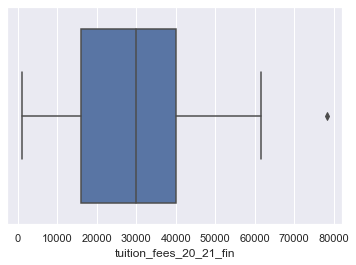

In [35]:
sns.boxplot(schools_df.tuition_fees_20_21_fin)

In [36]:
schools_df.loc[schools_df.tuition_fees_20_21 > 70000]

,school,raw_stu_to_fac_ratio,tuition_fees,books_supplies,tuition,fees,tuition_under,fees_under,ft_faculty,pt_faculty,...,act_comp_75_perc,act_eng_25_perc,act_eng_75_perc,act_math_25_perc,act_math_75_perc,grad_rate,tuition_20_21,fees_20_21,tuition_fees_20_21,tuition_fees_20_21_fin
79,MGH Institute of Health Professions,10 to 1,NaN,NaN,73200.0,5041.0,NaN,NaN,110.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,73200.0,5041.0,78241.0,78241.0


In [37]:
max_tuition_fees = schools_df.tuition_fees_20_21.max()

#### Drop outlier and any rows with nan in tuition_fees_20_21_fin (our target variable for the linear regression)

In [38]:
schools_df = schools_df.loc[schools_df.tuition_fees_20_21_fin < max_tuition_fees]

In [39]:
schools_df.dropna(subset=['tuition_fees_20_21_fin'], inplace=True)

In [40]:
schools_df.shape # by dropping nan and outlier in tuition_fees_20_21_fin, we lost 10 rows

(1322, 42)

### Clean enrollment columns

In [41]:
schools_df[['school','total_enroll', 'total_enroll_under', 'under_enroll', 'under_trans_enroll', 'grad_enroll']].sample(10)

,school,total_enroll,total_enroll_under,under_enroll,under_trans_enroll,grad_enroll
353,The King's College,NaN,442.0,NaN,24.0,NaN
142,Kettering College,763.0,NaN,566.0,91.0,197.0
8,Azusa Pacific University,9006.0,NaN,4498.0,208.0,4508.0
44,College of the Holy Cross,NaN,2970.0,NaN,14.0,NaN
113,University of Miami,17809.0,NaN,11334.0,608.0,6475.0
45,University of Dubuque,2180.0,NaN,1778.0,48.0,402.0
62,Aultman College of Nursing and Health Sciences,NaN,355.0,NaN,66.0,NaN
272,Family of Faith Christian University,148.0,NaN,42.0,2.0,106.0
73,Butler University,5544.0,NaN,4492.0,63.0,1052.0
387,Women's Institute of Torah Seminary and College,NaN,147.0,NaN,76.0,NaN


In [42]:
schools_df['total_under_enroll'] = np.nan

In [43]:
schools_df['total_under_enroll'].fillna(schools_df.total_enroll_under, inplace=True)

In [44]:
schools_df['total_under_enroll'].fillna(schools_df.under_enroll, inplace=True)

In [45]:
# check that in new col, where total_enroll_under has a value, it was assigned to the new col
total_enroll_under_not_nan = schools_df.loc[~schools_df.total_enroll_under.isna()]
total_enroll_under_not_nan[['total_under_enroll', 'total_enroll_under', 'under_enroll']].sample(5)

,total_under_enroll,total_enroll_under,under_enroll
296,242.0,242.0,NaN
300,628.0,628.0,NaN
397,869.0,869.0,NaN
62,355.0,355.0,NaN
74,1140.0,1140.0,NaN


In [46]:
# check that in new col, where under_enroll has a value, it was assigned to the new col
under_enroll_not_nan = schools_df.loc[~schools_df.under_enroll.isna()]
under_enroll_not_nan[['total_under_enroll', 'total_enroll_under', 'under_enroll']].sample(5)

,total_under_enroll,total_enroll_under,under_enroll
80,5430.0,NaN,5430.0
138,1704.0,NaN,1704.0
189,2544.0,NaN,2544.0
326,2355.0,NaN,2355.0
324,2690.0,NaN,2690.0


In [47]:
# drop total_enroll_under and under_enroll columns
#schools_df.drop(['total_enroll_under', 'under_enroll'],axis=1, inplace=True)

In [48]:
# drop total_enroll (i.e., the sum of under_enroll, under_trans_enroll, and grad_enroll, 
    # since not enough schools have grad programs to consider info about them 
#schools_df.drop(['total_enroll', 'grad_enroll'], axis=1, inplace=True)

#### Investigate the 5 schools with nan in new total_under_enroll column and the under_trans_enroll column

In [49]:
total_under_enroll_nan = schools_df.loc[(schools_df.total_under_enroll.isna()) & (schools_df.under_trans_enroll.isna())]
total_under_enroll_nan[['school', 'total_under_enroll', 'under_trans_enroll']]

,school,total_under_enroll,under_trans_enroll
24,Montana Bible College,NaN,NaN
257,Zaytuna College,NaN,NaN
308,Southwest University of Visual Arts-Tucson,NaN,NaN
341,Faith Theological Seminary and Christian College,NaN,NaN
255,Maple Springs Baptist Bible College and Seminary,NaN,NaN


- Montana Bible College: according to NCES website, "Data not available."
- Zaytuna College: " "
- Southwest University of Visual Arts-Tucson: " "
- Faith Theological Seminary and Christian College: " "
- Maple Springs Baptist Bible College and Seminary: according to NCES website, "School failed to provide data and is subject to administrative action, including a fine or termination of eligibility to participate in federal student aid."

In [50]:
# look at other columns for these schools to see if they are worth keeping in for other 
    # info besides enrollment data
#total_under_enroll_nan.iloc[:,:15]

In [51]:
#total_under_enroll_nan.iloc[:,15:]

In [52]:
# drop Zaytuna College, Southwest University of Visual Arts-Tucson, and 
    # Faith Theological Seminary and Christian College, since the only feature for which
    # they have data is the price of books and supplies in 20-21
#schools_drop_no_enroll_data = ['Zaytuna College', 'Southwest University of Visual Arts-Tucson',
                             # 'Faith Theological Seminary and Christian College']
#schools_df = schools_df[schools_df.school.isin(schools_drop_no_enroll_data) == False]

#### Look at summary statistics of total_under_enroll column and its distribution to determine what values to assign the other two schools with missing datda in the total_under_enroll column

In [53]:
schools_df[['total_under_enroll']].describe()

,total_under_enroll
count,1317.000000
mean,2056.615793
std,5230.832683
min,2.000000
25%,365.000000
50%,1109.000000
75%,2161.000000
max,111599.000000


<AxesSubplot:xlabel='total_under_enroll', ylabel='Count'>

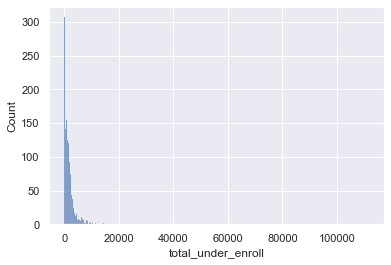

In [54]:
sns.histplot(schools_df.total_under_enroll)

<AxesSubplot:xlabel='total_under_enroll'>

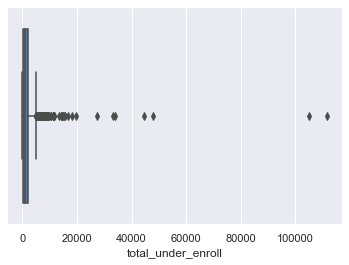

In [55]:
sns.boxplot(schools_df.total_under_enroll)

#### Since there are many outliers in the total_under_enroll column, assign the median of that column to the five schools missing data in that column.

In [56]:
total_under_enroll_med = schools_df['total_under_enroll'].median()
schools_df.total_under_enroll.fillna(total_under_enroll_med, inplace=True)

In [57]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 0 to 131
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1322 non-null   object 
 1   raw_stu_to_fac_ratio                     1317 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1211 non-null   float64
 4   tuition                                  47 non-null     float64
 5   fees                                     47 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1308 non-null   float64
 9   pt_faculty                               1308 non-null   float64
 10  avg_amt_grant_schol_aid_beg_under_19_20  1275 non

### Clean student-to-faculty ratio column

In [58]:
# look at values in raw_stu_to_fac_ratio
schools_df['raw_stu_to_fac_ratio'].value_counts()

12 to 1                                                                                                                                                                                                                                   168
11 to 1                                                                                                                                                                                                                                   152
10 to 1                                                                                                                                                                                                                                   134
13 to 1                                                                                                                                                                                                                                   127
14 to 1                                         

In [59]:
# look at unique values in raw_stu_to_fac_ratio column to see if there's extra white space
schools_df['raw_stu_to_fac_ratio'].unique()

array(['6 to 1', '8 to 1', '4 to 1', '5 to 1', '7 to 1', '3 to 1',
       '10 to 1', '11 to 1', '9 to 1', '14 to 1', '2 to 1', '16 to 1',
       '21 to 1', '20 to 1', '15 to 1', '33 to 1', nan, '12 to 1',
       '18 to 1', '13 to 1', '26 to 1', '19 to 1', '22 to 1', '23 to 1',
       '17 to 1', '1 to 1',
       '3 to 1View noteThe institution had a significant decrease in enrollment for the 2020-21 year, while retaining its full-time faculty.',
       "13 to 1View noteDue to the COVID-19 pandemic, USD's undergraduate enrollment for Fall 2020 was lower than in previous fall terms resulting in a lower student-to-faculty ratio.",
       '42 to 1', '28 to 1',
       '4 to 1View notePlease interpret these data in the context of the COVID-19 pandemic, which has created some anomalies and fluctuations in enrollment and related statistics.',
       '25 to 1', '31 to 1', '30 to 1', '40 to 1', '35 to 1', '27 to 1',
       '12 to 1View noteThe reduction in the student faculty ratio is directly re

In [60]:
# create a list containing the str value in the column raw_stu_to_fac_ratio
stu_to_fac_ratio_ls = [row for row in schools_df['raw_stu_to_fac_ratio'].astype(str)]

In [61]:
# split each str value in the list into a list, so there are inner lists, one per str
stu_to_fac_ratio_ls = [ele.split(' ') for ele in stu_to_fac_ratio_ls]

In [62]:
print(stu_to_fac_ratio_ls[0])
print(stu_to_fac_ratio_ls[0][2][0])

['6', 'to', '1']
1


In [63]:
for lst in stu_to_fac_ratio_ls:
    if len(lst) == 1:
        print(lst)

['nan']
['nan']
['nan']
['nan']
['nan']


In [64]:
# create a list that keeps just the first three elements in each inner list
stu_to_fac_ratio_ls_rev = [ls[:3] for ls in stu_to_fac_ratio_ls] 

In [65]:
for lst in stu_to_fac_ratio_ls_rev:
    if len(lst) == 1:
        print(lst)

['nan']
['nan']
['nan']
['nan']
['nan']


In [66]:
# loop through the new list to find the indices of the inner lists whose third element
    # is of length greater than one

indices = []

for i in range(0, len(stu_to_fac_ratio_ls_rev)):
    if len(stu_to_fac_ratio_ls_rev[i]) > 1:
        if len(stu_to_fac_ratio_ls_rev[i][2]) > 1:
            indices.append(i)

In [67]:
# print out the lists whose third element is of length greater than one

for i in indices:
    print(stu_to_fac_ratio_ls_rev[i])

['3', 'to', '1View']
['13', 'to', '1View']
['4', 'to', '1View']
['12', 'to', '1View']
['21', 'to', '1View']


In [68]:
# create a final list that fixes inner lists whose third element has 'View' in it

stu_to_fac_ratio_ls_rev_2 = []

for i in range(0, len(stu_to_fac_ratio_ls_rev)):
    if i in indices:
        first_char = stu_to_fac_ratio_ls_rev[i][0]
        second_char = stu_to_fac_ratio_ls_rev[i][1]
        third_char = stu_to_fac_ratio_ls_rev[i][2].replace('1View','1')
        stu_to_fac_ratio_ls_rev_2.append([first_char, second_char, third_char])
    else:
        stu_to_fac_ratio_ls_rev_2.append(stu_to_fac_ratio_ls_rev[i])

In [69]:
# delete elements in each inner list that are the word 'to'

for ele in stu_to_fac_ratio_ls_rev_2:
    if len(ele) > 1:
        del ele[1]

In [70]:
# replace inner lists that are ['nan'] with ['0', '1'] so that next the elements in every
    # inner list can be converted to integers and math can be done on them

stu_to_fac_ratio_ls_rev_3 = []

for ele in stu_to_fac_ratio_ls_rev_2:
    if len(ele) <= 1:
        new_ele = ele[0].replace("nan", "0")
        second_new_ele = '1'
        stu_to_fac_ratio_ls_rev_3.append([new_ele, second_new_ele])
    else:
        stu_to_fac_ratio_ls_rev_3.append(ele)

In [71]:
# convert elements in inner lists to type integer

stu_to_fac_ratio_ls_rev_3 = [[int(x) for x in lst] for lst in stu_to_fac_ratio_ls_rev_3]

In [72]:
# create a new list of inner lists that each contian the result of the first element
    # divided by the second element of each inner list

stu_to_fac_ratio_ls_rev_4 = [[lst[0] / lst[1]] for lst in stu_to_fac_ratio_ls_rev_3]

In [73]:
# flatten the above list so each new float value isn't in its own list

flattened_stu_to_fac_ratio = [item for sublist in stu_to_fac_ratio_ls_rev_4 for item in sublist]

In [74]:
# add cleaned student-to-faculty ratio list back to df

schools_df['stu_to_fac_ratio'] = flattened_stu_to_fac_ratio

#### Look at summary statistics and distribution of new student-to-faculty ratio column

<AxesSubplot:xlabel='stu_to_fac_ratio', ylabel='Count'>

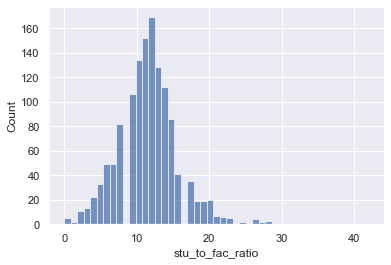

In [75]:
sns.histplot(schools_df['stu_to_fac_ratio'])

<AxesSubplot:xlabel='stu_to_fac_ratio'>

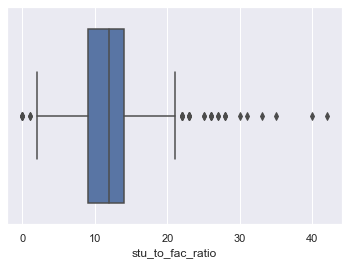

In [76]:
sns.boxplot(schools_df['stu_to_fac_ratio'])

In [77]:
schools_df['stu_to_fac_ratio'].describe()

count    1322.000000
mean       11.630862
std         4.361578
min         0.000000
25%         9.000000
50%        12.000000
75%        14.000000
max        42.000000
Name: stu_to_fac_ratio, dtype: float64

In [78]:
schools_df.loc[schools_df.stu_to_fac_ratio == 0]

,school,raw_stu_to_fac_ratio,tuition_fees,books_supplies,tuition,fees,tuition_under,fees_under,ft_faculty,pt_faculty,...,act_eng_75_perc,act_math_25_perc,act_math_75_perc,grad_rate,tuition_20_21,fees_20_21,tuition_fees_20_21,tuition_fees_20_21_fin,total_under_enroll,stu_to_fac_ratio
24,Montana Bible College,NaN,9040.0,300.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,43.0,NaN,NaN,NaN,9040.0,1109.0,0.0
257,Zaytuna College,NaN,19250.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19250.0,1109.0,0.0
308,Southwest University of Visual Arts-Tucson,NaN,23069.0,1038.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23069.0,1109.0,0.0
341,Faith Theological Seminary and Christian College,NaN,1520.0,300.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1520.0,1109.0,0.0
255,Maple Springs Baptist Bible College and Seminary,NaN,5400.0,260.0,NaN,NaN,NaN,NaN,1.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5400.0,1109.0,0.0


#### Replace rows originally missing data in this feature (and now with value of 0) with the median of the column

In [79]:
stu_to_fac_ratio_med = schools_df['stu_to_fac_ratio'].median()
schools_df.loc[schools_df['stu_to_fac_ratio'] == 0, 'stu_to_fac_ratio'] = stu_to_fac_ratio_med
#schools_df['stu_to_fac_ratio'] = schools_df['stu_to_fac_ratio'].map(lambda x: stu_to_fac_ratio_med if x == 0.0 else x)

In [80]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 0 to 131
Data columns (total 44 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1322 non-null   object 
 1   raw_stu_to_fac_ratio                     1317 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1211 non-null   float64
 4   tuition                                  47 non-null     float64
 5   fees                                     47 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1308 non-null   float64
 9   pt_faculty                               1308 non-null   float64
 10  avg_amt_grant_schol_aid_beg_under_19_20  1275 non

In [81]:
# drop the rows with 0 in the new stu_to_fac_ratio column, since those were missing values
    # in the original student-to-faculty ratio column
#schools_df = schools_df.loc[schools_df.stu_to_fac_ratio != 0]

In [82]:
# drop raw_stu_to_fac_ratio column from dataframe
#schools_df.drop(['raw_stu_to_fac_ratio'],axis=1,inplace=True)

### Clean books and supplies columns

#### Look at spread of books_supplies column

<AxesSubplot:xlabel='books_supplies', ylabel='Count'>

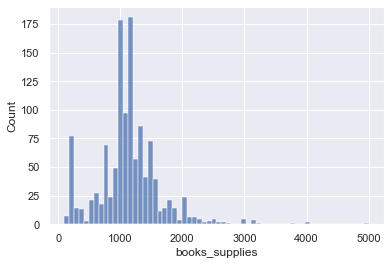

In [83]:
sns.histplot(schools_df.books_supplies)

In [84]:
schools_df[['books_supplies']].describe()

,books_supplies
count,1211.000000
mean,1146.397192
std,516.229418
min,100.000000
25%,921.000000
50%,1144.000000
75%,1344.000000
max,5000.000000


#### Since the mean and median are almost exactly the same, it seems like I can pick either value to impute the value of this variable for schools with missing data; I'll use median.

In [85]:
books_supplies_med = schools_df['books_supplies'].median()
schools_df.books_supplies.fillna(books_supplies_med, inplace=True)

In [86]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 0 to 131
Data columns (total 44 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1322 non-null   object 
 1   raw_stu_to_fac_ratio                     1317 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1322 non-null   float64
 4   tuition                                  47 non-null     float64
 5   fees                                     47 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1308 non-null   float64
 9   pt_faculty                               1308 non-null   float64
 10  avg_amt_grant_schol_aid_beg_under_19_20  1275 non

### Clean faculty columns

#### Look at spread of each column

In [87]:
schools_df[['ft_faculty', 'pt_faculty']].describe()

,ft_faculty,pt_faculty
count,1308.000000,1308.000000
mean,191.829511,145.144495
std,585.284160,301.983767
min,0.000000,0.000000
25%,22.750000,21.000000
50%,69.000000,64.000000
75%,149.250000,159.250000
max,6927.000000,6340.000000


<AxesSubplot:xlabel='ft_faculty', ylabel='Count'>

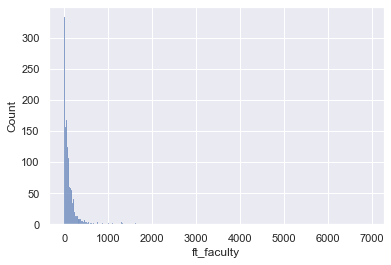

In [88]:
sns.histplot(schools_df['ft_faculty'])

<AxesSubplot:xlabel='pt_faculty', ylabel='Count'>

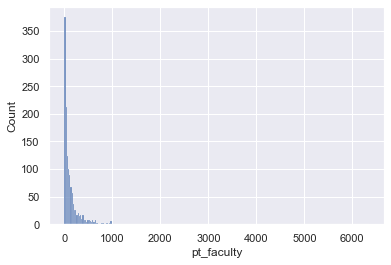

In [89]:
sns.histplot(schools_df['pt_faculty'])

#### Since the distribution of both columns is right-skewed, I will use the medians to impute them for schools missing this data.

In [90]:
ft_faculty_med = schools_df['ft_faculty'].median()
schools_df.ft_faculty.fillna(ft_faculty_med, inplace=True)

In [91]:
pt_faculty_med = schools_df['pt_faculty'].median()
schools_df.pt_faculty.fillna(pt_faculty_med, inplace=True)

### Clean applications columns

#### Look at schools missing number of undergraduate applications

In [92]:
# there are 237 schools missing data in this column
len(schools_df.loc[schools_df['under_apps'].isna()])

236

In [93]:
# I'll randomly research 23 of them on NCES' website

under_apps_nan = schools_df.loc[schools_df['under_apps'].isna()]
under_apps_nan[['school']].sample(23)

,school
87,Talmudic College of Florida
153,Lincoln Christian University
53,Riverside College of Health Careers
286,Bon Secours Memorial College of Nursing
281,Jarvis Christian College
244,Walla Walla University
64,Holy Apostles College and Seminary
188,Pacific Bible College
313,City College-Miami
330,Bethlehem College & Seminary


#### Of the 23 schools I randomly sampled who didn't have undergraduate application data:
    - 6 (~26%) stated it's because they don't admit full-time first-time degree/certificate-seeking students
    - 16 (~70%) stated it's because they have an open admission policy
    - 1 (!4%) stated it's because they're not required to provide admissions or test score data

- Samuel Merritt University: 'This institution does not admit full-time first-time degree/certificate-seeking students, therefore admission information was not reported.'
- Atlantic Institute of Oriental Medicine: " "
- Oak Point University: " "
- Touro University Nevada: " "
- Sentara College of Health Sciences: " "
- Rush University: " "
- Parker University: 'This institution has an open admission policy. Contact the institution for more information.'
- Virginia University of Lynchburg: " "
- Walla Walla University: " "
- Martin University: " "
- Bethlehem College & Seminary: " "
- Beulah Heights University: " "
- Jarvis Christian College: " "
- Pittsburgh Technical College: " "
- Talmudic College of Florida: '" "
- Rabbinical College Ohr Yisroel: " "
- Remington College-Shreveport Campus: " "
- Ohio Christian University: " "
- Yeshiva Yesoda Hatorah Vetz Chaim: " "
- Faith International University: " "
- Miles College: " "
- Lincoln University: " "
- Central Yeshiva Beth Joseph: "This institution was not required to provide admissions or test score data."

#### Create new column to code for the presence or absence of admissions data. The absence represents those who likely have an open admissions policy or don't admit full-time first-time degree/certificate seeking students.

In [94]:
# add column that indicates presence or absence of admissions data on NCES school page
schools_df['admiss_data'] = schools_df.under_apps.map(lambda x: 1 if not np.isnan(x) else 0)

In [95]:
# check new column
schools_df['admiss_data'].value_counts()

1    1086
0     236
Name: admiss_data, dtype: int64

#### Look at spread of under_apps and perc_admitted

In [96]:
schools_df[['under_apps', 'perc_admitted']].describe()

,under_apps,perc_admitted
count,1086.000000,1086.000000
mean,4439.233886,68.193370
std,7860.829967,21.779655
min,1.000000,0.000000
25%,576.250000,57.000000
50%,2016.500000,72.000000
75%,4710.500000,83.000000
max,80210.000000,100.000000


<AxesSubplot:xlabel='under_apps', ylabel='Count'>

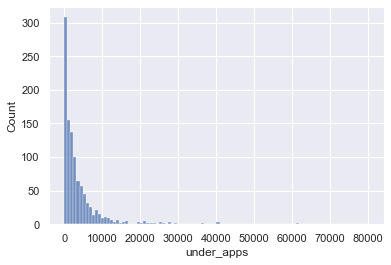

In [97]:
sns.histplot(schools_df.under_apps)

<AxesSubplot:xlabel='perc_admitted', ylabel='Count'>

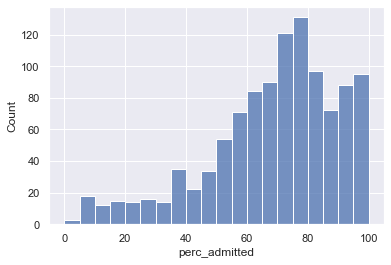

In [98]:
sns.histplot(schools_df.perc_admitted)

#### Since under_apps column is right-skewed, inpute the median for the schools with missing data in the under_apps column. For the perc_admitted column, impute 100%, since most of the schools I sampled who are missing admissions data have open admissions, so the argument could be made that they admit 100% of those who apply.

In [99]:
under_apps_med = schools_df.under_apps.median()
schools_df.under_apps.fillna(under_apps_med, inplace=True)

In [100]:
schools_df.perc_admitted.fillna(100.0, inplace=True)

In [101]:
# re-scale perc_admitted so it's from 0-1 instead of 0-100
schools_df['perc_admitted_fin'] = schools_df['perc_admitted'] / 100

### Clean financial aid columns

#### Investigate the NCES pages of the 10 schools missing average amount of grant or scholarship aid received by undergrad students in 2019-20

In [102]:
schools_df.loc[schools_df.avg_amt_grant_schol_aid_all_under_19_20.isna()]

,school,raw_stu_to_fac_ratio,tuition_fees,books_supplies,tuition,fees,tuition_under,fees_under,ft_faculty,pt_faculty,...,act_math_75_perc,grad_rate,tuition_20_21,fees_20_21,tuition_fees_20_21,tuition_fees_20_21_fin,total_under_enroll,stu_to_fac_ratio,admiss_data,perc_admitted_fin
183,Northwestern Polytechnic University,2 to 1,8720.0,1210.0,NaN,NaN,NaN,NaN,4.0,4.0,...,NaN,33.0,NaN,NaN,NaN,8720.0,6.0,2.0,1,0.46
193,Pacific States University,5 to 1,12960.0,1687.0,NaN,NaN,NaN,NaN,2.0,8.0,...,NaN,1.0,NaN,NaN,NaN,12960.0,2.0,5.0,0,1.00
257,Zaytuna College,NaN,19250.0,200.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,19250.0,1109.0,12.0,0,1.00
308,Southwest University of Visual Arts-Tucson,NaN,23069.0,1038.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,23069.0,1109.0,12.0,0,1.00
264,Atlantic Institute of Oriental Medicine,6 to 1,NaN,1144.0,17000.0,595.0,NaN,NaN,6.0,0.0,...,NaN,NaN,17000.0,595.0,17595.0,17595.0,69.0,6.0,0,1.00
340,Fairfax University of America,4 to 1,10328.0,1200.0,NaN,NaN,NaN,NaN,10.0,32.0,...,NaN,17.0,NaN,NaN,NaN,10328.0,17.0,4.0,0,1.00
341,Faith Theological Seminary and Christian College,NaN,1520.0,300.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,1520.0,1109.0,12.0,0,1.00
126,W L Bonner College,3 to 1,NaN,1144.0,NaN,NaN,5148.0,268.0,1.0,5.0,...,NaN,NaN,5148.0,268.0,5416.0,5416.0,21.0,3.0,0,1.00
213,Gratz College,12 to 1,NaN,1144.0,19648.0,985.0,NaN,NaN,4.0,25.0,...,NaN,NaN,19648.0,985.0,20633.0,20633.0,159.0,12.0,0,1.00
62,Hebrew College,1 to 1,NaN,1144.0,29760.0,240.0,NaN,NaN,9.0,31.0,...,NaN,NaN,29760.0,240.0,30000.0,30000.0,26.0,1.0,0,1.00


- Northwestern Polytechnic University: $0 in total amount of aid received column
- Pacific States University: " "
- Atlantic Institute of Oriental Medicine: " "
- Fairfax University of America: 'Average amounts are withheld to preserve the confidentiality of individuals.' (17 undergrad students)
- Gratz College: " " (159 undergrad students)
- Hebrew College: " " (26 undergrad students)
- W L Bonner College: "Data not available."
- Zaytuna College: " "
- Southwest University of Visual Arts-Tucson: " "
- Faith Theological Seminary and Christian College: " "

#### Look at spread of this column

In [103]:
schools_df[['avg_amt_grant_schol_aid_all_under_19_20']].describe()

,avg_amt_grant_schol_aid_all_under_19_20
count,1312.000000
mean,17932.379573
std,10981.613718
min,582.000000
25%,8504.500000
50%,16838.000000
75%,24478.000000
max,58244.000000


<AxesSubplot:xlabel='avg_amt_grant_schol_aid_all_under_19_20', ylabel='Count'>

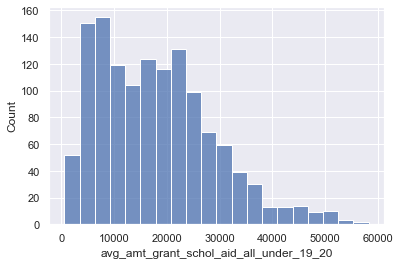

In [104]:
sns.histplot(schools_df.avg_amt_grant_schol_aid_all_under_19_20)

#### Assign '0' to the three schools with $0 under 'Total amount of aid received'; impute the median average amount of aid for the other seven schools missing values in this column.

In [105]:
schools_zero_aid = ['Northwestern Polytechnic University', 'Pacific States University',
                   'Atlantic Institute of Oriental Medicine']
schools_df.loc[schools_df.school.isin(schools_zero_aid),['avg_amt_grant_schol_aid_all_under_19_20']] = 0

In [106]:
schools_med_aid = ['Fairfax University of America', 'Gratz College','Hebrew College','W L Bonner College',
                  'Zaytuna College', 'Faith Theological Seminary and Christian College', 'Southwest University of Visual Arts-Tucson']
avg_amt_grant_schol_aid_all_under_19_20_med = schools_df['avg_amt_grant_schol_aid_all_under_19_20'].median()
schools_df.loc[schools_df.school.isin(schools_med_aid),['avg_amt_grant_schol_aid_all_under_19_20']] = avg_amt_grant_schol_aid_all_under_19_20_med

In [107]:
schools_df.loc[schools_df.school.isin(schools_med_aid)]

,school,raw_stu_to_fac_ratio,tuition_fees,books_supplies,tuition,fees,tuition_under,fees_under,ft_faculty,pt_faculty,...,act_math_75_perc,grad_rate,tuition_20_21,fees_20_21,tuition_fees_20_21,tuition_fees_20_21_fin,total_under_enroll,stu_to_fac_ratio,admiss_data,perc_admitted_fin
257,Zaytuna College,NaN,19250.0,200.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,19250.0,1109.0,12.0,0,1.0
308,Southwest University of Visual Arts-Tucson,NaN,23069.0,1038.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,23069.0,1109.0,12.0,0,1.0
340,Fairfax University of America,4 to 1,10328.0,1200.0,NaN,NaN,NaN,NaN,10.0,32.0,...,NaN,17.0,NaN,NaN,NaN,10328.0,17.0,4.0,0,1.0
341,Faith Theological Seminary and Christian College,NaN,1520.0,300.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,1520.0,1109.0,12.0,0,1.0
126,W L Bonner College,3 to 1,NaN,1144.0,NaN,NaN,5148.0,268.0,1.0,5.0,...,NaN,NaN,5148.0,268.0,5416.0,5416.0,21.0,3.0,0,1.0
213,Gratz College,12 to 1,NaN,1144.0,19648.0,985.0,NaN,NaN,4.0,25.0,...,NaN,NaN,19648.0,985.0,20633.0,20633.0,159.0,12.0,0,1.0
62,Hebrew College,1 to 1,NaN,1144.0,29760.0,240.0,NaN,NaN,9.0,31.0,...,NaN,NaN,29760.0,240.0,30000.0,30000.0,26.0,1.0,0,1.0


In [108]:
# drop avg_amt_grant_schol_aid_beg_under_19_20 since it's messy because of the way the data was scraped, 
    # some values in avg_amt_grant_schol_aid_beg_under_19_20 are actually avg_amt_grant_schol_aid_all_under_19_20
schools_df.drop(['avg_amt_grant_schol_aid_beg_under_19_20'],axis=1, inplace=True)

In [109]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 0 to 131
Data columns (total 45 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1322 non-null   object 
 1   raw_stu_to_fac_ratio                     1317 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1322 non-null   float64
 4   tuition                                  47 non-null     float64
 5   fees                                     47 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1322 non-null   float64
 9   pt_faculty                               1322 non-null   float64
 10  avg_amt_grant_schol_aid_all_under_19_20  1322 non

### Clean graduation rate column

#### Since there are 102 schools missing graduation rate data, sample 10 to investigate in NCES

In [110]:
schools_df.loc[schools_df.grad_rate.isna()]['school'].sample(10)

101                       Saint John's Seminary
45                              College Unbound
42                       Christ Mission College
102    Trinity International University-Florida
14            Yeshiva Shaarei Torah of Rockland
205       Roseman University of Health Sciences
348      Florida Institute of Technology-Online
266               Yellowstone Christian College
208                   Samuel Merritt University
170                 Central Yeshiva Beth Joseph
Name: school, dtype: object

- Yeshiva Ohr Naftoli: "This institution did not admit full-time first-time undergraduate-level students in the cohort year, therefore graduation rate information was not reported."
- Florida Institute of Technology-Online: " "
- Antioch University-Santa Barbara: " "
- Helene Fuld College of Nursing: " "
- National University of Health Sciences: " "
- Hult International Business School: " "
- National University of Natural Medicine: "This institution did not offer programs at or below the baccalaureate level, therefore graduation rate information was not reported."
- Bais Medrash Elyon " "
- William James College: " "
- Champion Christian College: "This institution was not in operation in 2014—2015, therefore graduation rate information was not reported."

It appears that a common reason for missing graduation rate data is that the school didn't have the right undergrad data for the year it's from, which is 2014-15. 

#### Look at spread of graduation rate column to determine how to impute null values

In [111]:
schools_df['grad_rate'].describe()

count    1221.000000
mean       55.184275
std        21.427796
min         0.000000
25%        42.000000
50%        57.000000
75%        70.000000
max        98.000000
Name: grad_rate, dtype: float64

<AxesSubplot:xlabel='grad_rate', ylabel='Count'>

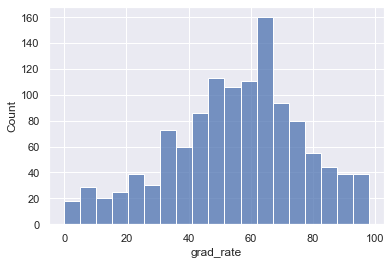

In [112]:
sns.histplot(schools_df['grad_rate'])

#### I'll impute the median to be consistent with other variables for whom I've imputed values, but since the distribution is pretty normal, mean could also be used.

In [113]:
schools_df.grad_rate.fillna(schools_df.grad_rate.median(), inplace=True)

In [114]:
# re-scale grad_rate so it's from 0-1 instead of 0-100
schools_df['grad_rate_fin'] = schools_df['grad_rate'] / 100

### Clean test score columns

#### Replace nans in test_scores_admiss_con, test_scores_req, test_scores_rec, and test_scores_con_not_req with 0

In [115]:
subset = ['test_scores_admiss_con', 'test_scores_req', 'test_scores_rec', 
            'test_scores_con_not_req']

for col in subset:
    schools_df[col]=schools_df[col].fillna(0)

#### More than half of the rest of the test score columns have missing values, but for now, we'll look at the summary statistics of most of them to impute the missing values using mean or median.

In [116]:
schools_df[['sat_read_write_25_perc', 'sat_read_write_75_perc', 'sat_math_25_perc', 'sat_math_75_perc',
           'act_comp_25_perc', 'act_comp_75_perc', 'act_eng_25_perc', 'act_eng_75_perc', 'act_math_25_perc',
           'act_math_75_perc']].describe()

,sat_read_write_25_perc,sat_read_write_75_perc,sat_math_25_perc,sat_math_75_perc,act_comp_25_perc,act_comp_75_perc,act_eng_25_perc,act_eng_75_perc,act_math_25_perc,act_math_75_perc
count,640.000000,640.000000,640.000000,640.000000,655.000000,655.000000,615.000000,615.000000,615.000000,615.000000
mean,522.454687,618.798437,516.734375,614.907812,21.071756,26.641221,20.208130,27.042276,19.603252,25.795122
std,74.287694,66.282496,82.445874,78.477188,4.675989,4.109489,5.363248,4.895471,4.257049,3.843050
min,300.000000,415.000000,200.000000,405.000000,10.000000,16.000000,9.000000,14.000000,10.000000,15.000000
25%,470.000000,570.000000,470.000000,560.000000,18.000000,24.000000,17.000000,23.500000,17.000000,24.000000
50%,510.000000,610.000000,500.000000,600.000000,20.000000,26.000000,19.000000,26.000000,18.000000,26.000000
75%,560.000000,660.000000,540.000000,660.000000,23.000000,29.000000,22.000000,31.000000,22.000000,28.000000
max,740.000000,780.000000,790.000000,800.000000,35.000000,36.000000,35.000000,36.000000,35.000000,36.000000


In [117]:
# write a function to compute the median of each scores column and replace nan values with them

scores_cols = ['sat_read_write_25_perc', 'sat_read_write_75_perc', 'sat_math_25_perc', 'sat_math_75_perc',
           'act_comp_25_perc', 'act_comp_75_perc', 'act_eng_25_perc', 'act_eng_75_perc', 'act_math_25_perc',
           'act_math_75_perc']

for col in scores_cols:
    med_val = schools_df[col].median()
    schools_df[col]=schools_df[col].fillna(med_val)

In [118]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 0 to 131
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1322 non-null   object 
 1   raw_stu_to_fac_ratio                     1317 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1322 non-null   float64
 4   tuition                                  47 non-null     float64
 5   fees                                     47 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1322 non-null   float64
 9   pt_faculty                               1322 non-null   float64
 10  avg_amt_grant_schol_aid_all_under_19_20  1322 non

## Create new dataframe that doesn't contain columns not needed for analysis

In [119]:
schools_df.columns

Index(['school', 'raw_stu_to_fac_ratio', 'tuition_fees', 'books_supplies',
       'tuition', 'fees', 'tuition_under', 'fees_under', 'ft_faculty',
       'pt_faculty', 'avg_amt_grant_schol_aid_all_under_19_20', 'total_enroll',
       'total_enroll_under', 'under_enroll', 'under_trans_enroll',
       'grad_enroll', 'under_apps', 'perc_admitted', 'test_scores_admiss_con',
       'test_scores_req', 'test_scores_rec', 'test_scores_con_not_req',
       'sat_scores_submit', 'perc_sat_scores_submit', 'act_scores_submit',
       'perc_act_scores_submit', 'sat_read_write_25_perc',
       'sat_read_write_75_perc', 'sat_math_25_perc', 'sat_math_75_perc',
       'act_comp_25_perc', 'act_comp_75_perc', 'act_eng_25_perc',
       'act_eng_75_perc', 'act_math_25_perc', 'act_math_75_perc', 'grad_rate',
       'tuition_20_21', 'fees_20_21', 'tuition_fees_20_21',
       'tuition_fees_20_21_fin', 'total_under_enroll', 'stu_to_fac_ratio',
       'admiss_data', 'perc_admitted_fin', 'grad_rate_fin'],
      dt

In [120]:
schools_df_rev = schools_df[['tuition_fees_20_21_fin','stu_to_fac_ratio','ft_faculty',
                             'pt_faculty','books_supplies','avg_amt_grant_schol_aid_all_under_19_20',
                             'total_under_enroll','admiss_data', 'under_apps','perc_admitted_fin',
                             'test_scores_req','test_scores_rec','test_scores_con_not_req', 'grad_rate_fin',
                             'sat_read_write_25_perc', 'sat_read_write_75_perc', 'sat_math_25_perc', 
                             'sat_math_75_perc','act_comp_25_perc', 'act_comp_75_perc', 'act_eng_25_perc', 
                             'act_eng_75_perc', 'act_math_25_perc','act_math_75_perc']]

In [121]:
schools_df_rev.columns

Index(['tuition_fees_20_21_fin', 'stu_to_fac_ratio', 'ft_faculty',
       'pt_faculty', 'books_supplies',
       'avg_amt_grant_schol_aid_all_under_19_20', 'total_under_enroll',
       'admiss_data', 'under_apps', 'perc_admitted_fin', 'test_scores_req',
       'test_scores_rec', 'test_scores_con_not_req', 'grad_rate_fin',
       'sat_read_write_25_perc', 'sat_read_write_75_perc', 'sat_math_25_perc',
       'sat_math_75_perc', 'act_comp_25_perc', 'act_comp_75_perc',
       'act_eng_25_perc', 'act_eng_75_perc', 'act_math_25_perc',
       'act_math_75_perc'],
      dtype='object')

In [122]:
# rename some columns
schools_df_rev.rename(columns={'tuition_fees_20_21_fin':'tuition_fees', 
                               'avg_amt_grant_schol_aid_all_under_19_20':'avg_grant_schol_aid',
                              'perc_admitted_fin':'accept_rate',
                              'grad_rate_fin':'grad_rate'},inplace=True)

#### Creates plot to look at relationships between target variable and continuous or discrete feature variables

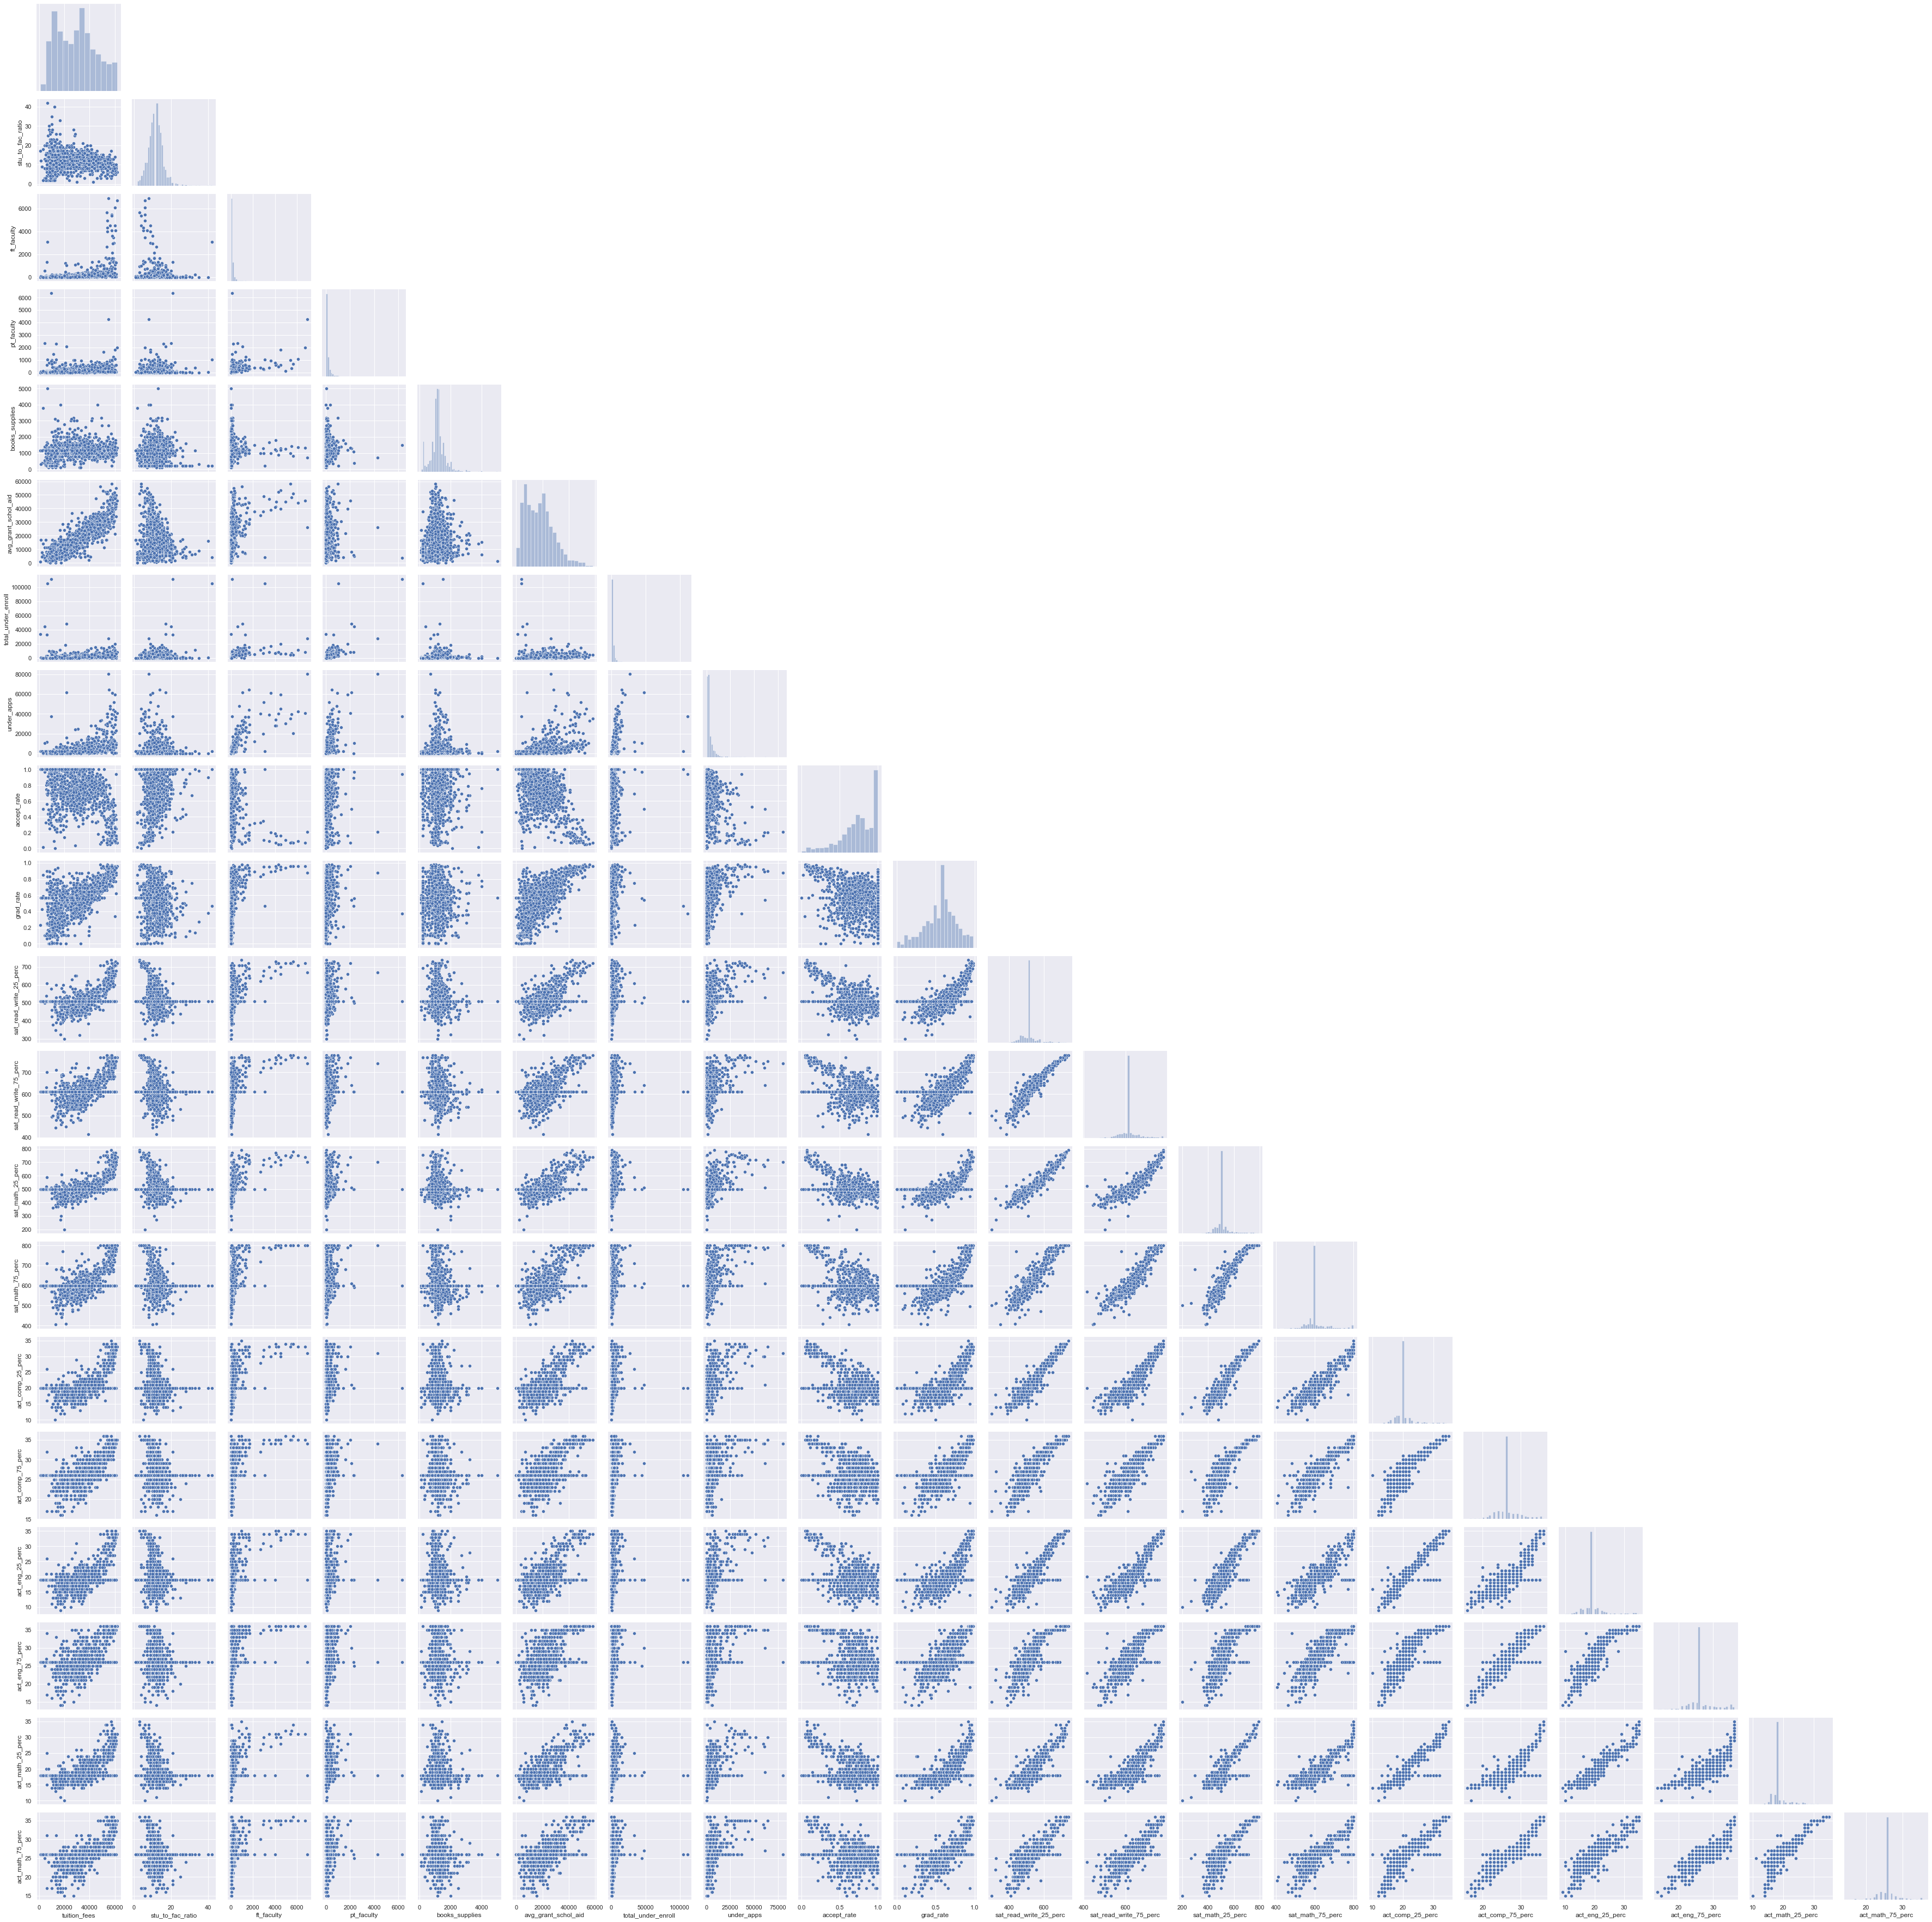

In [123]:
num_variables = ['tuition_fees', 'stu_to_fac_ratio','ft_faculty','pt_faculty','books_supplies',
                  'avg_grant_schol_aid','total_under_enroll','under_apps','accept_rate',
                  'grad_rate', 'sat_read_write_25_perc', 'sat_read_write_75_perc', 'sat_math_25_perc', 
                  'sat_math_75_perc','act_comp_25_perc', 'act_comp_75_perc', 'act_eng_25_perc', 
                 'act_eng_75_perc', 'act_math_25_perc','act_math_75_perc']

g = sns.PairGrid(schools_df_rev[num_variables], diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot, kde=False);

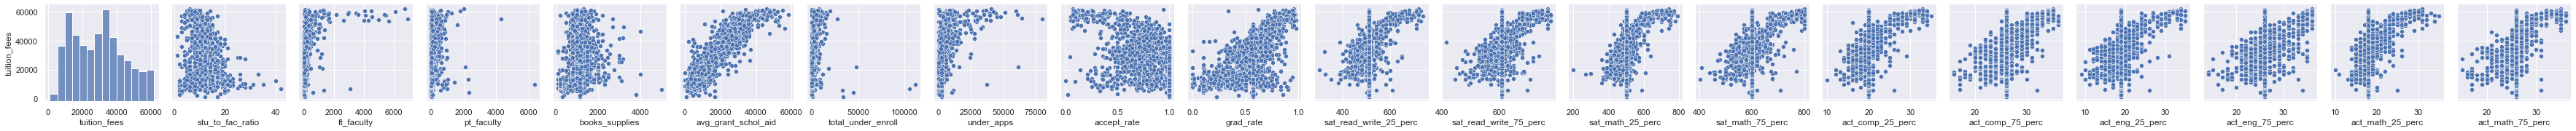

In [124]:
sns.pairplot(schools_df_rev, 
             y_vars=['tuition_fees'],
             x_vars=num_variables)

#### Look at correlation between all feature variables and target variable

In [125]:
schools_df_rev.corr()

,tuition_fees,stu_to_fac_ratio,ft_faculty,pt_faculty,books_supplies,avg_grant_schol_aid,total_under_enroll,admiss_data,under_apps,accept_rate,...,sat_read_write_25_perc,sat_read_write_75_perc,sat_math_25_perc,sat_math_75_perc,act_comp_25_perc,act_comp_75_perc,act_eng_25_perc,act_eng_75_perc,act_math_25_perc,act_math_75_perc
tuition_fees,1.000000,-0.141465,0.356873,0.181923,0.168697,0.875495,0.127477,0.426922,0.471090,-0.479116,...,0.474325,0.452576,0.498342,0.491385,0.519152,0.492825,0.482211,0.460944,0.516282,0.419086
stu_to_fac_ratio,-0.141465,1.000000,-0.093952,0.094020,-0.049048,-0.137812,0.240684,0.065952,-0.036321,0.143938,...,-0.180068,-0.172119,-0.179688,-0.173061,-0.178182,-0.154106,-0.172280,-0.132543,-0.169363,-0.151778
ft_faculty,0.356873,-0.093952,1.000000,0.461442,0.032512,0.393191,0.372508,0.112322,0.770359,-0.382086,...,0.521612,0.470271,0.555471,0.512402,0.530695,0.456608,0.487635,0.385931,0.509262,0.435408
pt_faculty,0.181923,0.094020,0.461442,1.000000,0.087062,0.108949,0.724457,0.104737,0.561188,-0.103291,...,0.192654,0.177036,0.197871,0.195737,0.200817,0.190546,0.165242,0.154988,0.166437,0.149158
books_supplies,0.168697,-0.049048,0.032512,0.087062,1.000000,0.053515,0.029003,0.059054,0.057544,-0.104159,...,-0.054131,-0.065278,-0.052574,-0.048175,-0.030701,-0.057788,-0.011770,-0.030315,-0.008981,-0.073912
avg_grant_schol_aid,0.875495,-0.137812,0.393191,0.108949,0.053515,1.000000,0.094568,0.411142,0.453432,-0.526670,...,0.490098,0.459294,0.526404,0.500855,0.530348,0.490043,0.500288,0.449842,0.531619,0.427946
total_under_enroll,0.127477,0.240684,0.372508,0.724457,0.029003,0.094568,1.000000,0.068485,0.484743,-0.086867,...,0.180655,0.171322,0.186331,0.185178,0.190345,0.186006,0.168110,0.164830,0.177428,0.157864
admiss_data,0.426922,0.065952,0.112322,0.104737,0.059054,0.411142,0.068485,1.000000,0.129188,-0.525288,...,0.054031,0.042894,0.065196,0.061096,0.074287,0.050926,0.070726,0.066941,0.115534,-0.016951
under_apps,0.471090,-0.036321,0.770359,0.561188,0.057544,0.453432,0.484743,0.129188,1.000000,-0.400557,...,0.536387,0.484605,0.565617,0.534105,0.560517,0.496882,0.515924,0.440640,0.529574,0.451401
accept_rate,-0.479116,0.143938,-0.382086,-0.103291,-0.104159,-0.526670,-0.086867,-0.525288,-0.400557,1.000000,...,-0.408330,-0.359053,-0.429316,-0.401256,-0.431384,-0.348952,-0.401832,-0.316636,-0.422915,-0.283662


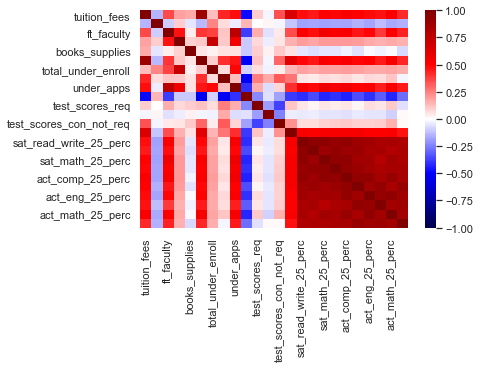

In [126]:
sns.heatmap(schools_df_rev.corr(), cmap="seismic", vmin=-1, vmax=1);

The only feature that is highly correlated with the target variable is avg_amt_grant_schol_aid_all_under_19_20 (the average amount of grant or scholarship aid received by undergrad students in 19-20, the most recent financial aid data available).

Looks like there's a lot of multicollinearity going on with the sat and act perctile columns! We'll leave them in for now, though...

#### Create dummy variables from categorical data

In [127]:
cat_variables = ['admiss_data', 'test_scores_req', 'test_scores_rec', 'test_scores_con_not_req']

schools_df_rev_dummies = pd.get_dummies(schools_df_rev, columns = cat_variables, drop_first=True)

## Create four datasets for modeling: 

1. financial aid data but no columns with 'SAT' or 'ACT' in the title
2. no financial aid data and no columns with 'SAT' or 'ACT' in the title
3. financial aid data and columns with 'SAT' or 'ACT' in the title
4. no financial aid data and columns with 'SAT' or 'ACT' in the title

In [128]:
schools_aid = schools_df_rev_dummies.copy()

In [129]:
schools_no_aid = schools_df_rev_dummies.copy()
schools_no_aid.drop(['avg_grant_schol_aid'], axis=1, inplace=True)

In [130]:
schools_aid_no_sat_act = schools_df_rev_dummies.copy()
schools_aid_no_sat_act.drop(['sat_read_write_25_perc', 'sat_read_write_75_perc', 'sat_math_25_perc', 
                  'sat_math_75_perc','act_comp_25_perc', 'act_comp_75_perc', 'act_eng_25_perc', 
                 'act_eng_75_perc', 'act_math_25_perc','act_math_75_perc'],axis=1,inplace=True)

In [131]:
schools_no_aid_no_sat_act = schools_df_rev_dummies.copy()
schools_no_aid_no_sat_act.drop(['avg_grant_schol_aid','sat_read_write_25_perc', 'sat_read_write_75_perc', 'sat_math_25_perc', 
                  'sat_math_75_perc','act_comp_25_perc', 'act_comp_75_perc', 'act_eng_25_perc', 
                 'act_eng_75_perc', 'act_math_25_perc','act_math_75_perc'],axis=1,inplace=True)

## Building a baseline model

#### Create simple linear regression model without sat/act percentile cols and evaluate it using cross_validate it

In [132]:
# define feature variables and target variable

X = schools_no_aid_no_sat_act.loc[:,['stu_to_fac_ratio', 'ft_faculty', 'pt_faculty',
       'books_supplies', 'total_under_enroll', 'under_apps', 'accept_rate', 'grad_rate',
       'admiss_data_1', 'test_scores_req_1.0', 'test_scores_rec_1.0',
       'test_scores_con_not_req_1.0']]

y = schools_no_aid_no_sat_act['tuition_fees']

In [133]:
# check that there's no multicollinearity between our feature variables using variance inflation factor
    # from statsmodels

def vif(X):
    '''
    Calculate the VIF for each feature of X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(X.values, i)
                for i in range(X.shape[1])]
    
    return pd.Series(vif_data, index=X.columns)

In [134]:
vif(X)

stu_to_fac_ratio               9.072660
ft_faculty                     2.805870
pt_faculty                     3.092230
books_supplies                 6.022666
total_under_enroll             2.671235
under_apps                     4.189776
accept_rate                    8.603995
grad_rate                      9.131776
admiss_data_1                  9.697661
test_scores_req_1.0            2.616663
test_scores_rec_1.0            1.768378
test_scores_con_not_req_1.0    3.266085
dtype: float64

Since the rule of thumb is to keep VIF below 10, our features look good and like we're not violating assumption #5 that says no independent variable is a linear function of another independent variable!

In [135]:
# build a train/val and test set

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42) #hold out 20% of the data for final testing

In [136]:
# split train/val data into multiple folds

kf = KFold(n_splits=5, shuffle=True, random_state = 71)

In [137]:
# Build and fit the model
lm = LinearRegression()
lm.fit(X_train_val, y_train_val)

cv_results_lm = cross_validate(lm, X_train_val, y_train_val, cv=kf, scoring='neg_root_mean_squared_error')
print(f"RMSE: {(cv_results_lm['test_score'])}")
print(f"mean RMSE: {(np.mean(cv_results_lm['test_score'])):.3f}")

RMSE: [ -9167.22062162  -9504.72099921 -11738.72571201 -10147.14480807
  -9673.69623035]
mean RMSE: -10046.302


In [138]:
# these are the original coefficients found

for col, coef in zip(X_train_val.columns, lm.coef_):
    print(f"{col:<16}: {coef:>12,.7f}")

stu_to_fac_ratio: -231.4183886
ft_faculty      :   -0.9682081
pt_faculty      :   -0.4195485
books_supplies  :    2.6962434
total_under_enroll:   -0.2006102
under_apps      :    0.6636502
accept_rate     : -3,311.9141571
grad_rate       : 31,459.9020328
admiss_data_1   : 8,654.4628144
test_scores_req_1.0: -469.5920512
test_scores_rec_1.0:  232.3545397
test_scores_con_not_req_1.0: 4,558.3553427


#### Evaluate the baseline model

Text(0, 0.5, 'Predictions')

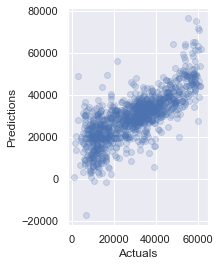

In [139]:
# Fitted (predicted) vs. Actual
y_train_val_pred = lm.predict(X_train_val)

plt.scatter(y_train_val, y_train_val_pred, alpha=0.2)
plt.axis('scaled')
plt.xlabel('Actuals')
plt.ylabel('Predictions')

Text(0, 0.5, 'Residuals')

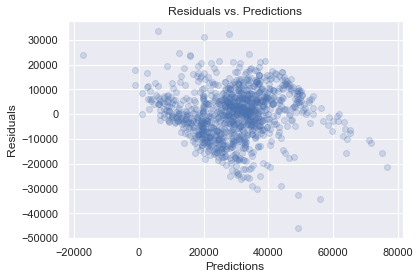

In [140]:
# Check violation of assumption 3:

# Residuals vs. predicted

lm_residuals = y_train_val - y_train_val_pred

plt.scatter(y_train_val_pred, lm_residuals, alpha=0.2)
plt.title("Residuals vs. Predictions")
plt.xlabel('Predictions')
plt.ylabel('Residuals')

(array([  1.,   3.,  14.,  62., 179., 326., 318., 129.,  22.,   3.]),
 array([-46099.66315234, -38125.90636598, -30152.14957962, -22178.39279326,
        -14204.6360069 ,  -6230.87922054,   1742.87756582,   9716.63435218,
         17690.39113855,  25664.14792491,  33637.90471127]),
 <BarContainer object of 10 artists>)

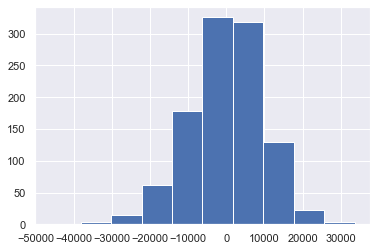

In [141]:
# Check violation of assumption 3:

# histogram of residuals

plt.hist(lm_residuals)

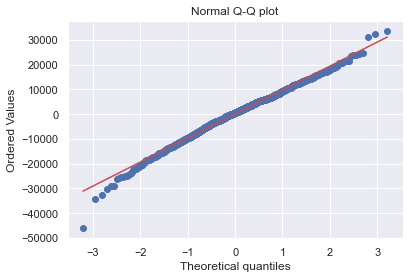

In [142]:
# Normal Q-Q plot
    
stats.probplot(lm_residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
    
plt.show()

The distribution of residuals is pretty normal and the Normal Q-Q plot looks good, since the middle section of dots are very close to the diagonal red line. So we've met assumption #2, which is that the residuals are normally distributed and have a zero mean!

## Create LASSOCV regression model

In [143]:
# make a copy of the dataset not including financial aid column (_reg in df name is for regularization)

schools_no_aid_no_sat_act_reg = schools_no_aid_no_sat_act.copy()

In [144]:
# standardize the numeric, non-binary variables

#list for cols to scale
cols_to_scale = ['stu_to_fac_ratio','ft_faculty','pt_faculty','books_supplies',
                 'total_under_enroll','under_apps','accept_rate','grad_rate']

#create scaler and fit
scaler = StandardScaler()

#scale selected data
schools_no_aid_no_sat_act_reg[cols_to_scale] = scaler.fit_transform(schools_no_aid_no_sat_act_reg[cols_to_scale])

In [145]:
# define the features again, since we standardized some some of them

X_reg = schools_no_aid_no_sat_act_reg.loc[:,['stu_to_fac_ratio', 'ft_faculty', 'pt_faculty',
       'books_supplies', 'total_under_enroll', 'under_apps', 'accept_rate', 'grad_rate',
       'admiss_data_1', 'test_scores_req_1.0', 'test_scores_rec_1.0',
       'test_scores_con_not_req_1.0']]

In [146]:
# split the data

# All data -> Train_val / test
X_train_val_reg, X_test_reg, y_train_val_reg, y_test_reg = train_test_split(X_reg, y, test_size=0.2,random_state=42)

In [147]:
# run the lasso cross validation and find the best alpha

alphavec = 10**np.linspace(-2,2,200)

lm_reg = LassoCV(alphas = alphavec, cv=5)
lm_reg.fit(X_train_val_reg, y_train_val_reg)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [148]:
# these are the (standardized) coefficients found when it refit using that best alpha

for col, coef in zip(X_train_val_reg.columns, lm_reg.coef_):
    print(f"{col:<16}: {coef:>12,.7f}")

stu_to_fac_ratio: -885.0442842
ft_faculty      : -199.7257299
pt_faculty      :   -0.0000000
books_supplies  : 1,249.1549063
total_under_enroll: -975.4478319
under_apps      : 4,255.2760825
accept_rate     : -884.7161832
grad_rate       : 6,468.0535731
admiss_data_1   : 7,768.1431488
test_scores_req_1.0:   -0.0000000
test_scores_rec_1.0:    0.0000000
test_scores_con_not_req_1.0: 4,482.2411742


#### Perform cross-validation

In [149]:
cv_results_lm_reg = cross_validate(lm_reg, X_train_val_reg, y_train_val_reg, cv=kf, scoring='neg_root_mean_squared_error')
print(f"RMSE: {(cv_results_lm_reg['test_score'])}")
print(f"mean RMSE: {(np.mean(cv_results_lm_reg['test_score'])):.3f}")

RMSE: [ -9190.60560863  -9486.55354171 -11738.64498829 -10151.80004527
  -9694.48550371]
mean RMSE: -10052.418


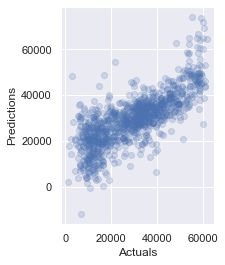

In [150]:
# Fitted (predicted) vs. Actual
y_train_val_reg_pred = lm_reg.predict(X_train_val_reg)

plot = plt.scatter(y_train_val_reg, y_train_val_reg_pred, alpha=0.2)
plt.axis('scaled')
plt.xlabel('Actuals')
plt.ylabel('Predictions')

print(plot)

Text(0, 0.5, 'Residuals')

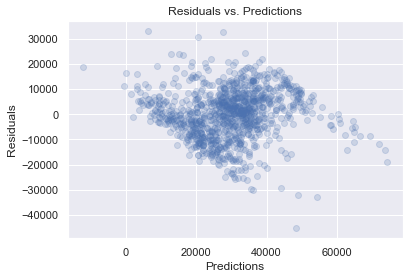

In [151]:
# Check violation of assumption 3:

# Residuals vs. predicted

lm_reg_residuals = y_train_val_reg - y_train_val_reg_pred

plt.scatter(y_train_val_reg_pred, lm_reg_residuals, alpha=0.2)
plt.title("Residuals vs. Predictions")
plt.xlabel('Predictions')
plt.ylabel('Residuals')

(array([  1.,   4.,  15.,  63., 175., 328., 308., 135.,  25.,   3.]),
 array([-45409.49216323, -37548.51771997, -29687.54327671, -21826.56883345,
        -13965.59439019,  -6104.61994693,   1756.35449633,   9617.32893959,
         17478.30338285,  25339.27782611,  33200.25226937]),
 <BarContainer object of 10 artists>)

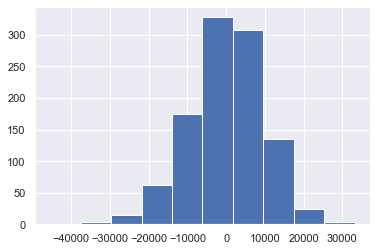

In [152]:
# histogram of residuals

plt.hist(lm_reg_residuals)

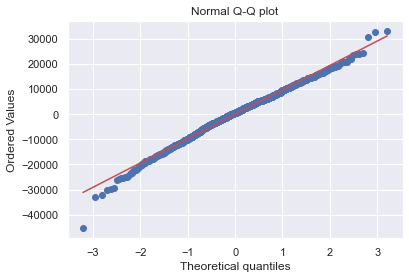

In [153]:
# Normal Q-Q plot
    
stats.probplot(lm_reg_residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
    
plt.show()

## Create function to repeatedly split X, y into the same train_val/test partitions to fit/score new models as I update the feature set and create plots

In [154]:
def split_and_validate(X, y):
    """For a set of features and target X, y, perform a 80/20 train_val/test split, 
    fit and validate a linear regression model, and report results.
    """
    
    # Train and validation split
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit linear regression to training/validation data
    lm = LinearRegression()
    lm.fit(X_train_val, y_train_val)
    
    # Fit and score model on training/validation data
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 71)
    cv_results = cross_validate(lm, X_train_val, y_train_val, cv=kf, scoring='neg_root_mean_squared_error')
    
    # Actuals vs Fitted (predicted) plot
    
    y_train_val_pred = lm.predict(X_train_val)

    plt1 = plt.figure(1)
    plt.scatter(y_train_val, y_train_val_pred, alpha=0.2)
    plt.axis('scaled')
    plt.xlabel('Actuals')
    plt.ylabel('Predictions')
    plt.title('Actuals vs Predictions')
    
    # Residuals vs. predicted plot

    lm_residuals = y_train_val - y_train_val_pred

    plt2 = plt.figure(2)
    plt.scatter(y_train_val_pred, lm_residuals, alpha=0.2)
    plt.title("Residuals vs. Predictions")
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    
    # Histogram of residuals
    
    plt3 = plt.figure(3)
    plt.hist(lm_residuals)
    plt.title('Distribution of residuals')
    
    plt.show()
    
    # Normal Q-Q plot
    
    plt4 = plt.figure(4)
    stats.probplot(lm_residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
    plt.show()
    
    # Report results
    print("")
    print(f"RMSE: {(cv_results['test_score'])}")
    print("")
    print(f"mean RMSE: {(np.mean(cv_results['test_score'])):.3f}")
    print('Feature coefficient results:')
    for feature, coef in zip(X.columns, lm.coef_):
        print(f"{feature:<20}: {coef:>12,.0f}") 

## Create simple linear regression model with select features, based on results from LASSO regression model

In [155]:
# define the features again, since we're removing pt_faculty, test_scores_req_1.0 and 
    #test_scores_rec_1.0

X2 = schools_no_aid_no_sat_act.loc[:,['stu_to_fac_ratio','books_supplies', 'total_under_enroll',
                           'ft_faculty','under_apps', 'accept_rate', 
                           'grad_rate','admiss_data_1','test_scores_con_not_req_1.0']]

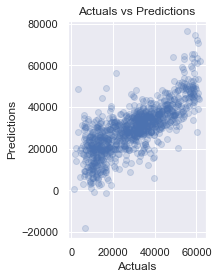

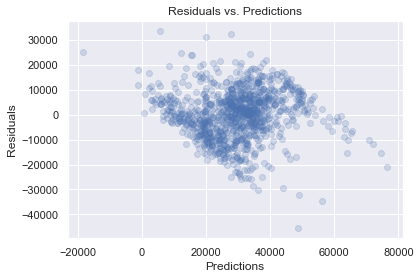

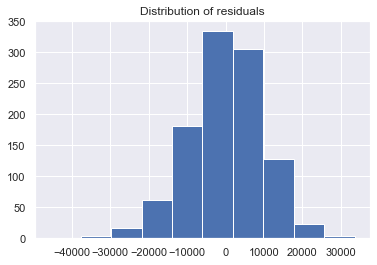

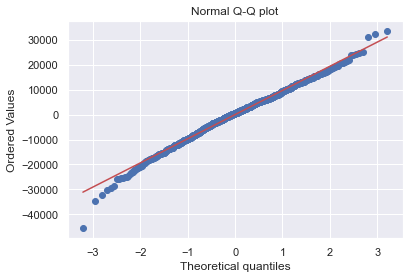


RMSE: [ -9172.01274613  -9501.61031098 -11243.63762959 -10090.91395126
  -9634.30592195]

mean RMSE: -9928.496
Feature coefficient results:
stu_to_fac_ratio    :         -230
books_supplies      :            3
total_under_enroll  :           -0
ft_faculty          :           -1
under_apps          :            1
accept_rate         :       -3,341
grad_rate           :       31,423
admiss_data_1       :        8,503
test_scores_con_not_req_1.0:        4,715


In [156]:
split_and_validate(X2,y)

## Create linear regression model degree 2 polynomial for grad_rate

In [157]:
# define new feature set

X3 = X2.copy()

X3['grad_rate'] = X3['grad_rate'] ** 2

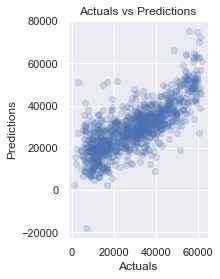

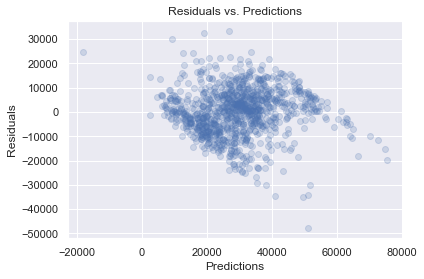

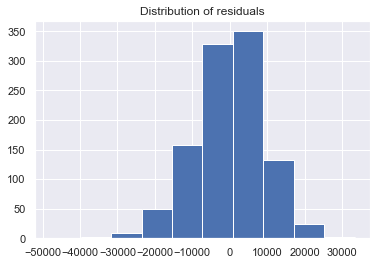

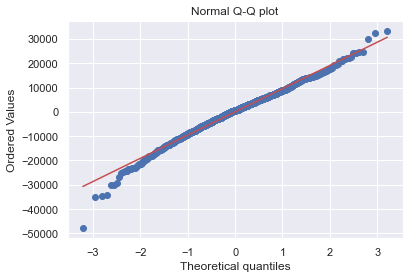


RMSE: [ -9000.75134978  -9386.51689371 -11005.41367733 -10168.00836284
  -9538.41945331]

mean RMSE: -9819.822
Feature coefficient results:
stu_to_fac_ratio    :         -188
books_supplies      :            3
total_under_enroll  :           -0
ft_faculty          :           -1
under_apps          :            1
accept_rate         :         -774
grad_rate           :       32,381
admiss_data_1       :        9,094
test_scores_con_not_req_1.0:        4,848


In [158]:
split_and_validate(X3,y)

## Create simple linear regression without financial aid but with sat/act percentile columns

In [164]:
# define feature variables and target variable

X_act_sat = schools_no_aid.loc[:,['stu_to_fac_ratio', 'ft_faculty', 'pt_faculty',
       'books_supplies', 'total_under_enroll', 'under_apps', 'accept_rate', 'grad_rate',
       'admiss_data_1', 'test_scores_req_1.0', 'test_scores_rec_1.0',
       'test_scores_con_not_req_1.0','sat_read_write_25_perc', 'sat_read_write_75_perc', 
        'sat_math_25_perc', 'sat_math_75_perc','act_comp_25_perc', 'act_comp_75_perc', 
        'act_eng_25_perc', 'act_eng_75_perc', 'act_math_25_perc','act_math_75_perc']]

y_act_sat = schools_no_aid['tuition_fees']

In [161]:
# check for multicollinearity (which we already expect, based on pair plots and heatmap of correlations)
vif(X_act_sat)

stu_to_fac_ratio                  9.655708
ft_faculty                        3.022050
pt_faculty                        3.181434
books_supplies                    6.660270
total_under_enroll                2.692841
under_apps                        4.464435
accept_rate                      20.244847
grad_rate                        13.249434
admiss_data_1                    11.978522
test_scores_req_1.0               3.016376
test_scores_rec_1.0               1.770417
test_scores_con_not_req_1.0       3.766707
sat_read_write_25_perc         1804.581926
sat_read_write_75_perc         2033.606960
sat_math_25_perc               1299.420191
sat_math_75_perc               1517.881193
act_comp_25_perc                891.514972
act_comp_75_perc               1827.612699
act_eng_25_perc                 519.575671
act_eng_75_perc                 861.218466
act_math_25_perc                471.609298
act_math_75_perc                958.093489
dtype: float64

Let's remove the columns that have variance inflation factors of over 1000 and see what happens when we calculate the vifs again.

In [163]:
# remove features with factors of over 1000 and see what happens
vif(X_act_sat[['stu_to_fac_ratio', 'ft_faculty', 'pt_faculty',
       'books_supplies', 'total_under_enroll', 'under_apps', 'accept_rate', 'grad_rate',
       'admiss_data_1', 'test_scores_req_1.0', 'test_scores_rec_1.0',
       'test_scores_con_not_req_1.0','act_comp_25_perc','act_eng_25_perc','act_eng_75_perc',
               'act_math_25_perc', 'act_math_75_perc']])

stu_to_fac_ratio                 9.551443
ft_faculty                       2.997599
pt_faculty                       3.177337
books_supplies                   6.486921
total_under_enroll               2.686664
under_apps                       4.423828
accept_rate                     18.394405
grad_rate                       13.129477
admiss_data_1                   11.530911
test_scores_req_1.0              2.958741
test_scores_rec_1.0              1.770307
test_scores_con_not_req_1.0      3.710351
act_comp_25_perc               315.275484
act_eng_25_perc                397.226457
act_eng_75_perc                494.779224
act_math_25_perc               432.869767
act_math_75_perc               530.922003
dtype: float64

Since the vifs are still very high for the remaining act/sat percentile score columns, we won't proceed with building a model that includes them.

## Create simple linear regression with financial aid and without sat/act percentile columns

In [168]:
# define feature variables and target variable

X_aid = schools_aid_no_sat_act.loc[:,['stu_to_fac_ratio', 'ft_faculty', 'pt_faculty',
       'books_supplies', 'total_under_enroll', 'under_apps', 'accept_rate', 'grad_rate',
       'admiss_data_1', 'test_scores_req_1.0', 'test_scores_rec_1.0',
       'test_scores_con_not_req_1.0','avg_grant_schol_aid']]

y_aid = schools_aid['tuition_fees']

In [169]:
# check for multicollinearity
vif(X_aid)

stu_to_fac_ratio                9.079306
ft_faculty                      2.817080
pt_faculty                      3.146990
books_supplies                  6.027694
total_under_enroll              2.673824
under_apps                      4.385560
accept_rate                     8.682763
grad_rate                      12.301656
admiss_data_1                  10.300279
test_scores_req_1.0             2.617368
test_scores_rec_1.0             1.768463
test_scores_con_not_req_1.0     3.316217
avg_grant_schol_aid             7.817921
dtype: float64

By adding in avg_grant_schol_aid, the vifs of admiss_data_1 and grad_rate have increased to 10 and 12 respectively, but since these are so close to the rule of thumb that they shouldn't be over 10, we'll keep them our features set.

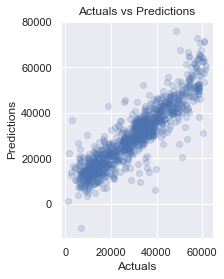

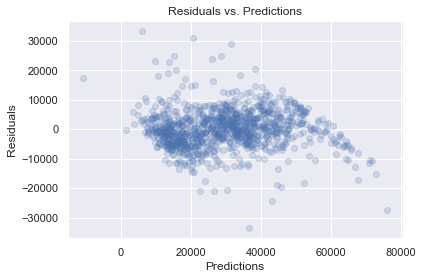

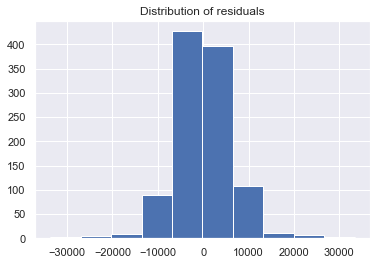

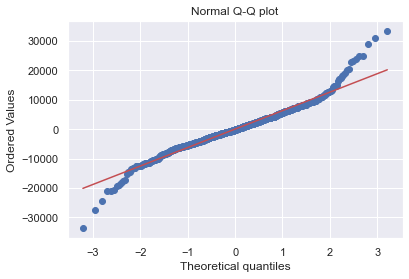


RMSE: [-5426.73013027 -6275.29829238 -7835.75634301 -7116.74544167
 -6949.87088128]

mean RMSE: -6720.880
Feature coefficient results:
stu_to_fac_ratio    :         -100
ft_faculty          :           -2
pt_faculty          :            3
books_supplies      :            4
total_under_enroll  :           -0
under_apps          :            0
accept_rate         :        3,954
grad_rate           :       12,363
admiss_data_1       :        4,698
test_scores_req_1.0 :       -1,553
test_scores_rec_1.0 :         -794
test_scores_con_not_req_1.0:          661
avg_grant_schol_aid :            1


In [170]:
split_and_validate(X_aid,y_aid)

## Create a LASSOCV model (including aid data)

In [175]:
# make a copy of the dataset not including financial aid column (_reg in df name is for regularization)

schools_aid_no_sat_act_reg = schools_aid_no_sat_act.copy()

In [176]:
# standardize the numeric, non-binary variables

#list for cols to scale
cols_to_scale = ['stu_to_fac_ratio','ft_faculty','pt_faculty','books_supplies',
                 'total_under_enroll','under_apps','accept_rate','grad_rate','avg_grant_schol_aid']

#create scaler and fit
scaler = StandardScaler()

#scale selected data
schools_aid_no_sat_act_reg[cols_to_scale] = scaler.fit_transform(schools_aid_no_sat_act_reg[cols_to_scale])

In [178]:
# define the features again, since we standardized some some of them

X_aid_reg = schools_aid_no_sat_act_reg.loc[:,['stu_to_fac_ratio', 'ft_faculty', 'pt_faculty',
       'books_supplies', 'total_under_enroll', 'under_apps', 'accept_rate', 'grad_rate',
       'admiss_data_1', 'test_scores_req_1.0', 'test_scores_rec_1.0',
       'test_scores_con_not_req_1.0', 'avg_grant_schol_aid']]

In [179]:
# split the data

# All data -> Train_val / test
X_train_val_aid_reg, X_test_aid_reg, y_train_val_aid_reg, y_test_aid_reg = train_test_split(X_aid_reg, y_aid, test_size=0.2,random_state=42)

In [180]:
# run the lasso cross validation and find the best alpha

alphavec = 10**np.linspace(-2,2,200)

lm_aid_reg = LassoCV(alphas = alphavec, cv=5)
lm_aid_reg.fit(X_train_val_aid_reg, y_train_val_aid_reg)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [181]:
# these are the (standardized) coefficients found when it refit using that best alpha

for col, coef in zip(X_train_val_aid_reg.columns, lm_aid_reg.coef_):
    print(f"{col:<16}: {coef:>12,.7f}")

stu_to_fac_ratio: -309.7014282
ft_faculty      : -993.3169029
pt_faculty      :  604.6900865
books_supplies  : 1,617.2314824
total_under_enroll: -296.2720881
under_apps      : 1,668.4626863
accept_rate     :  490.0689266
grad_rate       : 2,451.3804647
admiss_data_1   : 2,927.9315438
test_scores_req_1.0: -313.2996224
test_scores_rec_1.0:   -0.0000000
test_scores_con_not_req_1.0: 1,199.9851856
avg_grant_schol_aid: 10,695.0837034


#### Perform cross-validation

In [182]:
cv_results_lm_aid_reg = cross_validate(lm_aid_reg, X_train_val_aid_reg, y_train_val_aid_reg, cv=kf, scoring='neg_root_mean_squared_error')
print(f"RMSE: {(cv_results_lm_aid_reg['test_score'])}")
print(f"mean RMSE: {(np.mean(cv_results_lm_aid_reg['test_score'])):.3f}")

RMSE: [-5477.18314357 -6368.31877225 -7289.22068817 -6944.73971382
 -6979.00899502]
mean RMSE: -6611.694


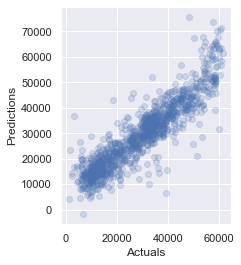

In [184]:
# Fitted (predicted) vs. Actual
y_train_val_aid_reg_pred = lm_aid_reg.predict(X_train_val_aid_reg)

plot = plt.scatter(y_train_val_aid_reg, y_train_val_aid_reg_pred, alpha=0.2)
plt.axis('scaled')
plt.xlabel('Actuals')
plt.ylabel('Predictions')

print(plot)

Text(0, 0.5, 'Residuals')

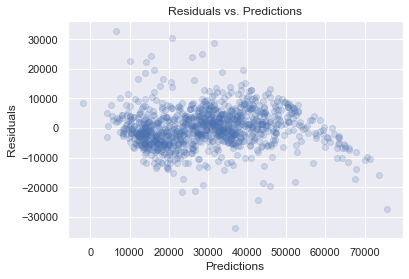

In [185]:
# Check violation of assumption 3:

# Residuals vs. predicted

lm_aid_reg_residuals = y_train_val_aid_reg - y_train_val_aid_reg_pred

plt.scatter(y_train_val_aid_reg_pred, lm_aid_reg_residuals, alpha=0.2)
plt.title("Residuals vs. Predictions")
plt.xlabel('Predictions')
plt.ylabel('Residuals')

(array([  2.,   3.,   9.,  85., 408., 396., 129.,  15.,   7.,   3.]),
 array([-33879.49373618, -27207.04262487, -20534.59151356, -13862.14040225,
         -7189.68929094,   -517.23817963,   6155.21293168,  12827.66404299,
         19500.1151543 ,  26172.56626561,  32845.01737692]),
 <BarContainer object of 10 artists>)

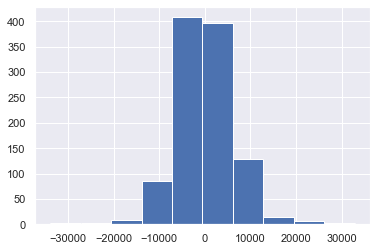

In [186]:
# histogram of residuals

plt.hist(lm_aid_reg_residuals)

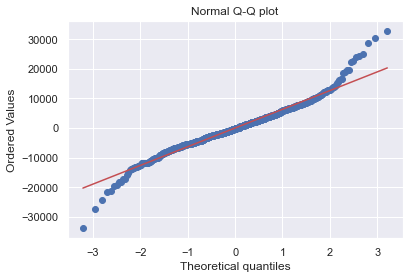

In [187]:
# Normal Q-Q plot
    
stats.probplot(lm_aid_reg_residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
    
plt.show()

## Create simple linear regression model with select features, based on results from LASSO regression model (and still with aid column)

In [188]:
# define the features again, since we're removing test_scores_rec_1.0

X_aid2 = schools_aid_no_sat_act.loc[:,['stu_to_fac_ratio','books_supplies', 'total_under_enroll',
                                       'ft_faculty','pt_faculty','under_apps', 'accept_rate', 
                                       'grad_rate','admiss_data_1','test_scores_req_1.0',
                                       'test_scores_con_not_req_1.0','avg_grant_schol_aid']]

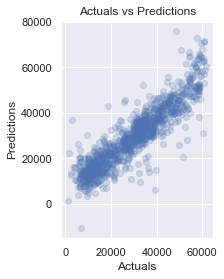

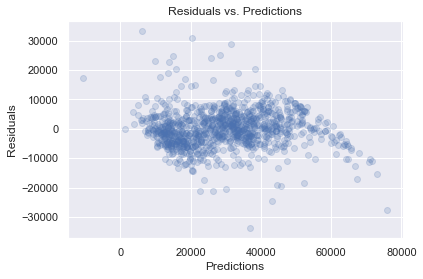

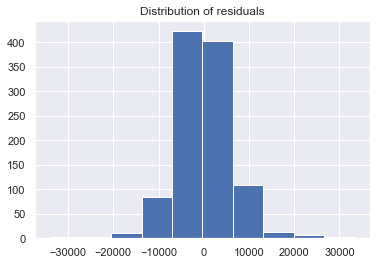

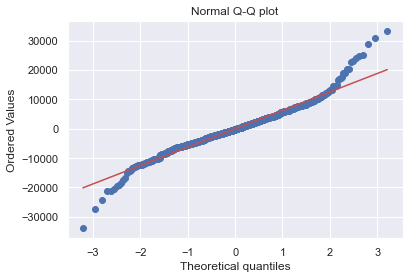


RMSE: [-5435.80318665 -6283.75343526 -7831.00952428 -6999.01109398
 -6958.12540825]

mean RMSE: -6701.541
Feature coefficient results:
stu_to_fac_ratio    :         -100
books_supplies      :            3
total_under_enroll  :           -0
ft_faculty          :           -2
pt_faculty          :            3
under_apps          :            0
accept_rate         :        3,945
grad_rate           :       12,321
admiss_data_1       :        4,350
test_scores_req_1.0 :       -1,182
test_scores_con_not_req_1.0:        1,038
avg_grant_schol_aid :            1


In [189]:
split_and_validate(X_aid2,y_aid)

## Create linear regression model degree 2 polynomial for grad_rate (and keep aid data)

In [190]:
X_aid3 = X_aid2.copy()

X_aid3['grad_rate'] = X_aid3['grad_rate'] ** 2

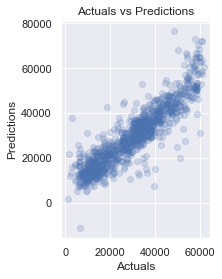

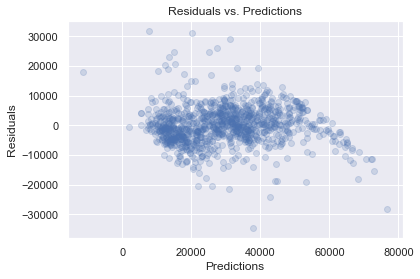

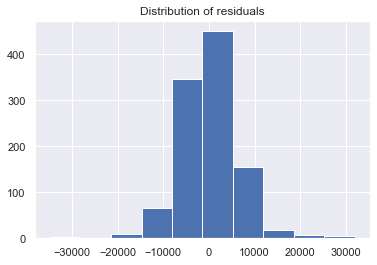

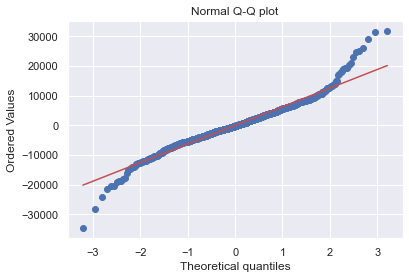


RMSE: [-5468.31866196 -6306.56850935 -7810.51582641 -7114.62992597
 -6987.54742394]

mean RMSE: -6737.516
Feature coefficient results:
stu_to_fac_ratio    :          -85
books_supplies      :            4
total_under_enroll  :           -0
ft_faculty          :           -2
pt_faculty          :            3
under_apps          :            0
accept_rate         :        4,750
grad_rate           :       12,296
admiss_data_1       :        4,544
test_scores_req_1.0 :       -1,030
test_scores_con_not_req_1.0:        1,208
avg_grant_schol_aid :            1


In [191]:
split_and_validate(X_aid3,y_aid)

## Record model scores down here

No financial aid and no SAT/ACT percentile columns (and after I replaced 0s (which were initially nans) in stu_to_fac_ratio with median and removed the single outlier from tuition_fees):
- Baseline model: mean RMSE is 10046.302
- LassoCV model: mean RMSE is 10052.418
- LM model that removes ft_faculty, pt_faculty, test_scores_req_1.0 and test_scores_rec_1.0, based on feature selection from the LassoCV model (pt_faculty, test_scores_req_1.0 and test_scores_rec_1.0 were all zero and ft_faculty was less than -500): 9928.496
- LM model that adds a polynomial term to grad_rate (degree 2): 9819.822

Financial aid but no SAT/ACT percentile columns (and after I replaced 0s (which were initially nans) in stu_to_fac_ratio with median and removed the single outlier from tuition_fees):
- Baseline model: mean RMSE is 6720.880
- LassoCV model: mean RMSE is 6611.694
- LM model that removes pt_faculty based on feature selection from the LassoCV model (pt_faculty was zero): 6701.541
- LM model that adds a polynomial term to grad_rate (degree 2): 6737.516

#### Plot the actual versus predicted results from the model and the diagonal line

In [159]:
# actuals versus predicted

#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#plt.scatter(x='Actual', y='Predicted', data=actuals_vs_predicted)
#plt.title('Actual vs Predicted \n Price of Tuition and Fees')

#fmt = '${x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.xaxis.set_major_formatter(tick) 
#ax.yaxis.set_major_formatter(tick)
#plt.xlabel('Actual Prices')
#plt.ylabel('Predicted Prices')

# diagonal line
#d_line= np.arange(actuals_vs_predicted.min().min(), actuals_vs_predicted.max().max())
#plt.plot(d_line, d_line, color='red', linestyle='--')

#plt.savefig('mvp_plot.png')

#### Plot the actual versus predicted results from the model and the diagonal line

In [160]:
#fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# create scatterplot of actual tuition and fee prices and line representing predicted tuition and fee prices
#ax.scatter(X_val, y_actual, color="black", alpha=.6)
#ax.plot(X_val, y_predicted, color="green", linewidth=3)

#fmt = '${x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.xaxis.set_major_formatter(tick) 
#ax.yaxis.set_major_formatter(tick)
#plt.xlabel('Average amount of grant or scholarship aid',size=12)
#plt.ylabel('Tuition and fees',size=12)
#plt.title("Tuition and Fees \n Predicted by Average Amount of Grant/Scholarship Aid",size=14)

#plt.savefig('mvp_plot_2.png')

#### Notes: 
- If perc_grant_schol_aid_beg_under_19_20 > 100, it means it's capturing # of students, not %
- if avg_amt_grant_schol_aid_beg_under_19_20 == avg_amt_grant_schol_aid_all_under_19_20, it means there's only data for 'All Undergraduate Students'

- Further web-scraping of admissions-related data:
    - if presence of admissions data, collect the following:
        1. presence (1) or absence (0) of 'Admission test scores (SAT/ACT)' under 'Admissions considerations'
            - if presence of 'Admission test scores (SAT/ACT)', collect presence or absence of:
                1. required (1) or not (0)
                2. recommended (1) or not (0)
                3. considered but not required (1) or not (0)